In [1]:
import pandas as pd
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import math
from sklearn import metrics
from statannot import add_stat_annotation
from collections import Counter
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from os import listdir
from os.path import isfile
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import networkx as nx
import pickle
import joblib

In [18]:
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 

In [19]:
PPI=pd.read_table('PPI/9606.protein.links.v11.5.txt',sep=' ')
uni_to_string_all_kin=pd.read_table('PPI/Uni_to_string_all_kin.txt',sep='\t')

In [20]:
kinases_id=pd.read_excel('KSA/kinase_table.xlsx')
kinases_id.index=kinases_id.Name
K_S_GPS=pd.read_csv('KSA/KSA_gold_standard.csv',index_col=0)

In [21]:
a_file = open("PanCan/all_sites_id_1cancer.pkl", "rb")
All_sites = pickle.load(a_file)

In [22]:
ks=list(set(K_S_GPS['Gene name']))

In [23]:
poor_kinase=[]
mid_kinase=[]
rich_kinase=[]
other_kinase=[]
poor_num=[]
mid_num=[]
rich_num=[]
other_num=[]
for i in ks:
    if 'family' not in i:
        if 'Isoform' not in i:
            tmp=K_S_GPS[K_S_GPS['Gene name']==i]
            if len(set(tmp['seq_15']))<=10:
                poor_kinase.append(i)
                poor_num.append(len(set(tmp['seq_15'])))
            if len(set(tmp['seq_15']))>10 and len(set(tmp['seq_15']))<=20:
                mid_kinase.append(i)
                mid_num.append(len(set(tmp['seq_15'])))
            if len(set(tmp['seq_15']))>20:
                rich_kinase.append(i)
                rich_num.append(len(set(tmp['seq_15'])))
            if len(set(tmp['seq_15']))>10:
                other_kinase.append(i)
                other_num.append(len(set(tmp['seq_15'])))

In [24]:
#CoPheeMap
network=pd.read_csv('CoPheeMap/data_construction/model_all_pos/All_positive_thred_9679.csv',index_col=0)
seq1=[i.split('|')[3] for i in network.index.tolist()]
seq2=[i.split('|')[3] for i in network.site2.tolist()]
network['seq1']=np.array(seq1)
network['seq2']=np.array(seq2)
sites=list(set(network.index.tolist()+network.site2.tolist()))
G = nx.Graph()
elist=list(zip(network.index.tolist(),network.site2.tolist()))
G.add_edges_from(elist)

idx_ST=[]
idx_Y=[]
for i in range(len(network)):
    if network.seq1.iloc[i][7] in ['S','T']:
        idx_ST.append(i)
    if network.seq1.iloc[i][7] in ['Y']:
        idx_Y.append(i)
network_ST=network.iloc[idx_ST,:]
network_Y=network.iloc[idx_Y,:]
lst_ST=list(set(network_ST.index.tolist()+network_ST.site2.tolist()))
H=G.subgraph(lst_ST)
nodes_ST=max(nx.connected_components(H))
G_ST=G.subgraph(nodes_ST)
network_Y=network.iloc[idx_Y,:]
lst_Y=list(set(network_Y.index.tolist()+network_Y.site2.tolist()))
H=G.subgraph(lst_Y)
nodes_Y=max(nx.connected_components(H))
G_Y=G.subgraph(nodes_Y)

In [295]:
len(nodes_ST)

25028

In [296]:
len(nodes_Y)

110

In [297]:
kk_emb=pd.read_csv('CoPheeKSA/kinase_network/n2v_KK_PPI_PCC.csv',index_col=0)
cophee_emb=pd.read_csv('CoPheeMap/data_construction/model_all_pos/n2v_networkST.csv', index_col=0)

In [298]:
k_list1=kk_emb.index.tolist()
mypath='CoPheeKSA/dynamic_features/all_data_for_kinase/'
onlyfiles = [f for f in listdir(mypath) if f!='.DS_Store']
k_list2=[i.split('_')[0] for i in onlyfiles]
mypath='CoPheeKSA/static_features/all'
onlyfiles = [f for f in listdir(mypath) if f!='.DS_Store']
k_list3=[i.split('_')[0] for i in onlyfiles]

kinase_covered=set(k_list1).intersection(k_list2)
kinase_covered=list(set(kinase_covered).intersection(k_list3))

In [4]:
import xgboost as xgb

In [317]:
#pssm
auc=[]
label=[]
for i in range(10):
    data_train=pd.read_csv('CoPheeKSA/static_features/test/test_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_train=data_train.dropna()
    data_neg=pd.read_csv('CoPheeKSA/negative/w_feature/negative.csv',index_col=0)
    data_neg=data_neg.drop_duplicates()
    idx=random.sample(range(len(data_neg)),10*len(data_train))
    data_neg=data_neg.iloc[idx]
    
    y=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_neg))))
    y_pred=np.concatenate((data_train.PSSM_score,data_neg.PSSM))
    fpr, tpr, _ = metrics.roc_curve(y,  y_pred)
    auc.append(metrics.auc(fpr, tpr))
    label.append('PSSM')

In [442]:
#Dynamic features + PSSM + CoPheeMap + KMap
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s','PSSM']
for i in range(10):
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_train=data_train[~data_train['PSSM'].isna()]
    
    data_neg=pd.read_csv('CoPheeKSA/negative/w_feature/negative.csv',index_col=0)
    data_neg=data_neg.drop_duplicates()
    data_neg.index=range(len(data_neg))
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
        
        c=tmp[['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']].isna().sum()
        for idx_col in ['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']:
            num=int(c.loc[idx_col]/len(tmp)*len(tmp2))
            idx=random.sample(tmp2.index.tolist(),num)
            
            for z in idx:
                tmp2.loc[z, idx_col]=np.nan
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_eval_neg=data_neg.iloc[idx]
    idx_removed=data_eval_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_test_neg=data_neg.iloc[idx]
    idx_removed=data_test_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_eval_neg=data_eval_neg[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_eval_neg])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_eval_neg))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)
    
    #auc.append(auc_tmp)
    #label.append('CoPheeKSA')

[0]	train-auc:0.87509	eval-auc:0.85608
[1]	train-auc:0.87755	eval-auc:0.85536
[2]	train-auc:0.88556	eval-auc:0.85288
[3]	train-auc:0.90057	eval-auc:0.87832
[4]	train-auc:0.90087	eval-auc:0.87832
[5]	train-auc:0.90208	eval-auc:0.87752
[6]	train-auc:0.90225	eval-auc:0.87736
[7]	train-auc:0.90614	eval-auc:0.87560
[8]	train-auc:0.90670	eval-auc:0.87440
[9]	train-auc:0.90739	eval-auc:0.87424
[10]	train-auc:0.90793	eval-auc:0.87576
[11]	train-auc:0.90882	eval-auc:0.87792
[12]	train-auc:0.91145	eval-auc:0.87728
[13]	train-auc:0.91312	eval-auc:0.90728
[14]	train-auc:0.91353	eval-auc:0.90672
[15]	train-auc:0.91458	eval-auc:0.90592
[16]	train-auc:0.91687	eval-auc:0.90552
[17]	train-auc:0.91857	eval-auc:0.90488
[18]	train-auc:0.92099	eval-auc:0.90432
[19]	train-auc:0.92229	eval-auc:0.90496
[20]	train-auc:0.92285	eval-auc:0.90576
[21]	train-auc:0.92461	eval-auc:0.90736
[22]	train-auc:0.92539	eval-auc:0.91472
[23]	train-auc:0.92697	eval-auc:0.91744


Pass `evals` as keyword args.


[24]	train-auc:0.92764	eval-auc:0.91392
[25]	train-auc:0.92823	eval-auc:0.91264
[26]	train-auc:0.92869	eval-auc:0.91696
[27]	train-auc:0.93040	eval-auc:0.91952
[28]	train-auc:0.93103	eval-auc:0.92080
[29]	train-auc:0.93155	eval-auc:0.92016
[30]	train-auc:0.93284	eval-auc:0.91744
[31]	train-auc:0.93372	eval-auc:0.91792
[32]	train-auc:0.93420	eval-auc:0.92128
[33]	train-auc:0.93457	eval-auc:0.92416
[34]	train-auc:0.93486	eval-auc:0.92304
[35]	train-auc:0.93528	eval-auc:0.92320
[36]	train-auc:0.93582	eval-auc:0.92368
[37]	train-auc:0.93640	eval-auc:0.92224
[38]	train-auc:0.93659	eval-auc:0.92432
[39]	train-auc:0.93713	eval-auc:0.92416
[40]	train-auc:0.93767	eval-auc:0.92512
[41]	train-auc:0.93792	eval-auc:0.92384
[42]	train-auc:0.93861	eval-auc:0.92464
[43]	train-auc:0.93891	eval-auc:0.92576
[44]	train-auc:0.93914	eval-auc:0.92704
[45]	train-auc:0.93957	eval-auc:0.92880
[46]	train-auc:0.94024	eval-auc:0.92736
[47]	train-auc:0.94060	eval-auc:0.92608
[48]	train-auc:0.94128	eval-auc:0.92480


Pass `evals` as keyword args.


[25]	train-auc:0.93104	eval-auc:0.94736
[26]	train-auc:0.93178	eval-auc:0.95008
[27]	train-auc:0.93208	eval-auc:0.95056
[28]	train-auc:0.93297	eval-auc:0.95072
[29]	train-auc:0.93342	eval-auc:0.95104
[30]	train-auc:0.93463	eval-auc:0.95136
[31]	train-auc:0.93574	eval-auc:0.95200
[32]	train-auc:0.93613	eval-auc:0.95200
[33]	train-auc:0.93673	eval-auc:0.95376
[34]	train-auc:0.93717	eval-auc:0.95408
[35]	train-auc:0.93776	eval-auc:0.95536
[36]	train-auc:0.93854	eval-auc:0.95584
[37]	train-auc:0.93872	eval-auc:0.95648
[38]	train-auc:0.93929	eval-auc:0.95712
[39]	train-auc:0.93988	eval-auc:0.95824
[40]	train-auc:0.94030	eval-auc:0.95824
[41]	train-auc:0.94053	eval-auc:0.95808
[42]	train-auc:0.94109	eval-auc:0.95856
[43]	train-auc:0.94147	eval-auc:0.95920
[44]	train-auc:0.94259	eval-auc:0.96112
[45]	train-auc:0.94282	eval-auc:0.96160
[46]	train-auc:0.94328	eval-auc:0.96208
[47]	train-auc:0.94370	eval-auc:0.96224
[48]	train-auc:0.94411	eval-auc:0.96224
[49]	train-auc:0.94419	eval-auc:0.96256


Pass `evals` as keyword args.


[22]	train-auc:0.92853	eval-auc:0.88552
[23]	train-auc:0.92916	eval-auc:0.88280
[24]	train-auc:0.92990	eval-auc:0.88632
[25]	train-auc:0.93077	eval-auc:0.88768
[26]	train-auc:0.93318	eval-auc:0.89072
[27]	train-auc:0.93334	eval-auc:0.89136
[28]	train-auc:0.93416	eval-auc:0.89312
[29]	train-auc:0.93451	eval-auc:0.89344
[30]	train-auc:0.93549	eval-auc:0.89488
[31]	train-auc:0.93630	eval-auc:0.89888
[32]	train-auc:0.93733	eval-auc:0.89968
[33]	train-auc:0.93813	eval-auc:0.89920
[34]	train-auc:0.93896	eval-auc:0.90064
[35]	train-auc:0.93943	eval-auc:0.90064
[36]	train-auc:0.93989	eval-auc:0.90144
[37]	train-auc:0.94029	eval-auc:0.90144
[38]	train-auc:0.94080	eval-auc:0.90320
[39]	train-auc:0.94121	eval-auc:0.90352
[40]	train-auc:0.94139	eval-auc:0.90320
[41]	train-auc:0.94180	eval-auc:0.90480
[42]	train-auc:0.94231	eval-auc:0.90784
[43]	train-auc:0.94268	eval-auc:0.90832
[44]	train-auc:0.94294	eval-auc:0.90896
[45]	train-auc:0.94332	eval-auc:0.90688
[46]	train-auc:0.94351	eval-auc:0.90736


Pass `evals` as keyword args.


0.920377142857143
[0]	train-auc:0.86118	eval-auc:0.80624
[1]	train-auc:0.86260	eval-auc:0.80536
[2]	train-auc:0.89585	eval-auc:0.86912
[3]	train-auc:0.90113	eval-auc:0.86808
[4]	train-auc:0.90144	eval-auc:0.86768
[5]	train-auc:0.90152	eval-auc:0.86688
[6]	train-auc:0.90287	eval-auc:0.86736
[7]	train-auc:0.90351	eval-auc:0.86936
[8]	train-auc:0.91098	eval-auc:0.90016
[9]	train-auc:0.91142	eval-auc:0.90120
[10]	train-auc:0.91146	eval-auc:0.90304
[11]	train-auc:0.91472	eval-auc:0.90112
[12]	train-auc:0.91487	eval-auc:0.90432
[13]	train-auc:0.91648	eval-auc:0.90744
[14]	train-auc:0.91656	eval-auc:0.90840
[15]	train-auc:0.91798	eval-auc:0.90848
[16]	train-auc:0.91892	eval-auc:0.90592
[17]	train-auc:0.91912	eval-auc:0.90816
[18]	train-auc:0.92064	eval-auc:0.90992
[19]	train-auc:0.92198	eval-auc:0.91248
[20]	train-auc:0.92322	eval-auc:0.91384
[21]	train-auc:0.92367	eval-auc:0.91384
[22]	train-auc:0.92519	eval-auc:0.91760
[23]	train-auc:0.92570	eval-auc:0.91872
[24]	train-auc:0.92709	eval-auc:

Pass `evals` as keyword args.


[26]	train-auc:0.92823	eval-auc:0.92096
[27]	train-auc:0.92880	eval-auc:0.92416
[28]	train-auc:0.92962	eval-auc:0.92320
[29]	train-auc:0.93037	eval-auc:0.92144
[30]	train-auc:0.93132	eval-auc:0.92432
[31]	train-auc:0.93188	eval-auc:0.92576
[32]	train-auc:0.93260	eval-auc:0.92784
[33]	train-auc:0.93282	eval-auc:0.92944
[34]	train-auc:0.93298	eval-auc:0.92816
[35]	train-auc:0.93352	eval-auc:0.92912
[36]	train-auc:0.93412	eval-auc:0.93024
[37]	train-auc:0.93462	eval-auc:0.93104
[38]	train-auc:0.93501	eval-auc:0.93248
[39]	train-auc:0.93617	eval-auc:0.93680
[40]	train-auc:0.93665	eval-auc:0.93840
[41]	train-auc:0.93711	eval-auc:0.93856
[42]	train-auc:0.93736	eval-auc:0.93872
[43]	train-auc:0.93810	eval-auc:0.94000
[44]	train-auc:0.93853	eval-auc:0.94032
[45]	train-auc:0.93885	eval-auc:0.94016
[46]	train-auc:0.93913	eval-auc:0.94144
[47]	train-auc:0.93965	eval-auc:0.94272
[48]	train-auc:0.93987	eval-auc:0.94224
[49]	train-auc:0.94035	eval-auc:0.94288
[50]	train-auc:0.94068	eval-auc:0.94320


Pass `evals` as keyword args.


[26]	train-auc:0.93019	eval-auc:0.86912
[27]	train-auc:0.93096	eval-auc:0.87096
[28]	train-auc:0.93137	eval-auc:0.87264
[29]	train-auc:0.93195	eval-auc:0.87328
[30]	train-auc:0.93232	eval-auc:0.87264
[31]	train-auc:0.93293	eval-auc:0.87440
[32]	train-auc:0.93402	eval-auc:0.87968
[33]	train-auc:0.93450	eval-auc:0.88240
[34]	train-auc:0.93517	eval-auc:0.88704
[35]	train-auc:0.93540	eval-auc:0.88816
[36]	train-auc:0.93557	eval-auc:0.88832
[37]	train-auc:0.93624	eval-auc:0.88688
[38]	train-auc:0.93713	eval-auc:0.88624
[39]	train-auc:0.93767	eval-auc:0.88656
[40]	train-auc:0.93803	eval-auc:0.88864
[41]	train-auc:0.93844	eval-auc:0.89104
[42]	train-auc:0.93921	eval-auc:0.89440
[43]	train-auc:0.93969	eval-auc:0.89360
[44]	train-auc:0.94016	eval-auc:0.89760
[45]	train-auc:0.94061	eval-auc:0.89792
[46]	train-auc:0.94096	eval-auc:0.89792
[47]	train-auc:0.94139	eval-auc:0.89824
[48]	train-auc:0.94194	eval-auc:0.89952
[49]	train-auc:0.94205	eval-auc:0.89984
[50]	train-auc:0.94259	eval-auc:0.90096


Pass `evals` as keyword args.


[23]	train-auc:0.92663	eval-auc:0.97280
[24]	train-auc:0.92753	eval-auc:0.97312
[25]	train-auc:0.92759	eval-auc:0.97296
[26]	train-auc:0.92920	eval-auc:0.97296
[27]	train-auc:0.93025	eval-auc:0.97392
[28]	train-auc:0.93094	eval-auc:0.97392
[29]	train-auc:0.93200	eval-auc:0.97440
[30]	train-auc:0.93266	eval-auc:0.97536
[31]	train-auc:0.93346	eval-auc:0.97552
[32]	train-auc:0.93356	eval-auc:0.97536
[33]	train-auc:0.93417	eval-auc:0.97552
[34]	train-auc:0.93481	eval-auc:0.97552
[35]	train-auc:0.93548	eval-auc:0.97616
[36]	train-auc:0.93601	eval-auc:0.97648
[37]	train-auc:0.93717	eval-auc:0.97600
[38]	train-auc:0.93751	eval-auc:0.97584
[39]	train-auc:0.93790	eval-auc:0.97616
[40]	train-auc:0.93832	eval-auc:0.97648
[41]	train-auc:0.93890	eval-auc:0.97680
[42]	train-auc:0.93920	eval-auc:0.97728
[43]	train-auc:0.93961	eval-auc:0.97664
[44]	train-auc:0.93995	eval-auc:0.97712
[45]	train-auc:0.94028	eval-auc:0.97968
[46]	train-auc:0.94079	eval-auc:0.98064
[47]	train-auc:0.94139	eval-auc:0.98064


Pass `evals` as keyword args.


0.917998811679493
[0]	train-auc:0.87856	eval-auc:0.83176
[1]	train-auc:0.88123	eval-auc:0.82872
[2]	train-auc:0.88271	eval-auc:0.83032
[3]	train-auc:0.90446	eval-auc:0.83256
[4]	train-auc:0.90500	eval-auc:0.83272
[5]	train-auc:0.90538	eval-auc:0.83232
[6]	train-auc:0.90573	eval-auc:0.83280
[7]	train-auc:0.90571	eval-auc:0.83280
[8]	train-auc:0.90665	eval-auc:0.83208
[9]	train-auc:0.90894	eval-auc:0.85720
[10]	train-auc:0.91192	eval-auc:0.85792
[11]	train-auc:0.91604	eval-auc:0.86752
[12]	train-auc:0.91769	eval-auc:0.86632
[13]	train-auc:0.91890	eval-auc:0.86608
[14]	train-auc:0.91979	eval-auc:0.86656
[15]	train-auc:0.92021	eval-auc:0.87024
[16]	train-auc:0.92083	eval-auc:0.87432
[17]	train-auc:0.92176	eval-auc:0.87440
[18]	train-auc:0.92275	eval-auc:0.87560
[19]	train-auc:0.92370	eval-auc:0.89728
[20]	train-auc:0.92475	eval-auc:0.89600
[21]	train-auc:0.92515	eval-auc:0.89536
[22]	train-auc:0.92633	eval-auc:0.89072
[23]	train-auc:0.92740	eval-auc:0.88720
[24]	train-auc:0.92812	eval-auc:

Pass `evals` as keyword args.


[27]	train-auc:0.93103	eval-auc:0.88600
[28]	train-auc:0.93174	eval-auc:0.88464
0.9296373456790124
[0]	train-auc:0.85625	eval-auc:0.80704
[1]	train-auc:0.88347	eval-auc:0.85024
[2]	train-auc:0.90041	eval-auc:0.87640
[3]	train-auc:0.90207	eval-auc:0.87592
[4]	train-auc:0.90424	eval-auc:0.87528
[5]	train-auc:0.90544	eval-auc:0.88976
[6]	train-auc:0.90544	eval-auc:0.88992
[7]	train-auc:0.90612	eval-auc:0.89056
[8]	train-auc:0.91242	eval-auc:0.90072
[9]	train-auc:0.91241	eval-auc:0.90096
[10]	train-auc:0.91324	eval-auc:0.90312
[11]	train-auc:0.91395	eval-auc:0.90744
[12]	train-auc:0.91417	eval-auc:0.90704
[13]	train-auc:0.91651	eval-auc:0.90672
[14]	train-auc:0.91728	eval-auc:0.90632
[15]	train-auc:0.91802	eval-auc:0.90552
[16]	train-auc:0.91957	eval-auc:0.90448
[17]	train-auc:0.92221	eval-auc:0.90400
[18]	train-auc:0.92304	eval-auc:0.90368
[19]	train-auc:0.92361	eval-auc:0.90416
[20]	train-auc:0.92483	eval-auc:0.91112
[21]	train-auc:0.92655	eval-auc:0.91568
[22]	train-auc:0.92712	eval-auc

Pass `evals` as keyword args.


[25]	train-auc:0.93007	eval-auc:0.92560
[26]	train-auc:0.93145	eval-auc:0.92848
[27]	train-auc:0.93224	eval-auc:0.92944
[28]	train-auc:0.93278	eval-auc:0.92992
[29]	train-auc:0.93354	eval-auc:0.93072
[30]	train-auc:0.93368	eval-auc:0.92992
[31]	train-auc:0.93463	eval-auc:0.93072
[32]	train-auc:0.93543	eval-auc:0.93216
[33]	train-auc:0.93584	eval-auc:0.93232
[34]	train-auc:0.93667	eval-auc:0.93600
[35]	train-auc:0.93710	eval-auc:0.93568
[36]	train-auc:0.93783	eval-auc:0.93568
[37]	train-auc:0.93841	eval-auc:0.93712
[38]	train-auc:0.93891	eval-auc:0.93712
[39]	train-auc:0.93909	eval-auc:0.93600
[40]	train-auc:0.93916	eval-auc:0.93504
[41]	train-auc:0.93963	eval-auc:0.93488
[42]	train-auc:0.94026	eval-auc:0.93888
[43]	train-auc:0.94071	eval-auc:0.93952
[44]	train-auc:0.94093	eval-auc:0.93968
[45]	train-auc:0.94144	eval-auc:0.94064
[46]	train-auc:0.94168	eval-auc:0.94000
[47]	train-auc:0.94216	eval-auc:0.94192
[48]	train-auc:0.94274	eval-auc:0.94112
[49]	train-auc:0.94324	eval-auc:0.94080


In [304]:
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


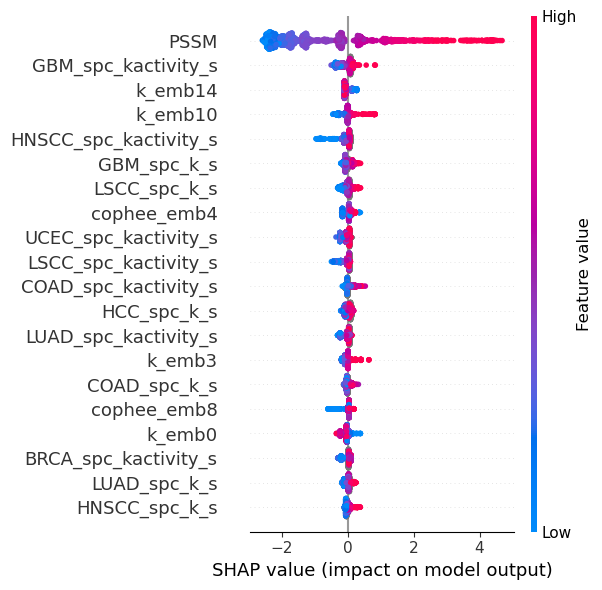

In [319]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)
plt_shap = shap.summary_plot(np.array(shap_values), #Use Shap values array
                             features=X_test, # Use training set features
                             feature_names=X_test.columns, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(6,6)) # Change plot size

In [320]:
#CoPheeMap + KMap
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15']
for i in range(10):
    data_neg=pd.read_csv('CoPheeKSA/negative/w_feature/negative.csv',index_col=0)
    data_neg=data_neg.drop_duplicates()
    data_neg=data_neg.replace(0,np.nan)
    data_neg.index=range(len(data_neg))
    #data_neg=data_neg[~data_neg['PSSM'].isna()]
    
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    #data_train=data_train[~data_train['PSSM'].isna()]
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    #data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_neg_eval=data_neg.iloc[idx,:]
    idx2=[i for i in range(len(data_neg)) if i not in idx]
    data_neg=data_neg.iloc[idx2,:]
    
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_neg_eval=data_neg_eval[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    #X_train=X_train.replace(np.nan,0)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_neg_eval])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_neg_eval))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)
    
    auc.append(auc_tmp)
    label.append('CoPheeMap+KMap')

[0]	train-auc:0.53853	eval-auc:0.56808
[1]	train-auc:0.59968	eval-auc:0.59632
[2]	train-auc:0.62253	eval-auc:0.60224
[3]	train-auc:0.61593	eval-auc:0.60016
[4]	train-auc:0.61505	eval-auc:0.59296
[5]	train-auc:0.61710	eval-auc:0.59216
[6]	train-auc:0.62256	eval-auc:0.63720
[7]	train-auc:0.62877	eval-auc:0.68616
[8]	train-auc:0.63577	eval-auc:0.65296
[9]	train-auc:0.64514	eval-auc:0.71184
[10]	train-auc:0.64428	eval-auc:0.68984
[11]	train-auc:0.65122	eval-auc:0.76344
[12]	train-auc:0.66053	eval-auc:0.79176
[13]	train-auc:0.66548	eval-auc:0.81104
[14]	train-auc:0.66739	eval-auc:0.82688
[15]	train-auc:0.67357	eval-auc:0.83856
[16]	train-auc:0.67531	eval-auc:0.83904
[17]	train-auc:0.67792	eval-auc:0.84168
[18]	train-auc:0.67919	eval-auc:0.84920
[19]	train-auc:0.68226	eval-auc:0.85008
[20]	train-auc:0.68307	eval-auc:0.85088
[21]	train-auc:0.68666	eval-auc:0.85408
[22]	train-auc:0.68950	eval-auc:0.85008
[23]	train-auc:0.69089	eval-auc:0.84560
[24]	train-auc:0.69416	eval-auc:0.85056
[25]	train

Pass `evals` as keyword args.


[46]	train-auc:0.73067	eval-auc:0.89568
[47]	train-auc:0.73208	eval-auc:0.89696
[48]	train-auc:0.73229	eval-auc:0.89712
[49]	train-auc:0.73461	eval-auc:0.89440
[50]	train-auc:0.73593	eval-auc:0.90128
[51]	train-auc:0.73710	eval-auc:0.90000
[52]	train-auc:0.73783	eval-auc:0.89792
[53]	train-auc:0.73910	eval-auc:0.89904
[54]	train-auc:0.74290	eval-auc:0.90320
[55]	train-auc:0.74371	eval-auc:0.90304
[56]	train-auc:0.74535	eval-auc:0.90480
[57]	train-auc:0.74671	eval-auc:0.90336
[58]	train-auc:0.74636	eval-auc:0.90496
[59]	train-auc:0.74632	eval-auc:0.90784
[60]	train-auc:0.74696	eval-auc:0.90864
[61]	train-auc:0.74721	eval-auc:0.90800
[62]	train-auc:0.75014	eval-auc:0.90992
[63]	train-auc:0.75111	eval-auc:0.90640
[64]	train-auc:0.75112	eval-auc:0.90560
[65]	train-auc:0.75225	eval-auc:0.90416
[66]	train-auc:0.75430	eval-auc:0.90256
[67]	train-auc:0.75541	eval-auc:0.90608
[68]	train-auc:0.75764	eval-auc:0.89808
[69]	train-auc:0.75912	eval-auc:0.89936
[70]	train-auc:0.76038	eval-auc:0.89568


Pass `evals` as keyword args.


0.7442132618801653
[0]	train-auc:0.54118	eval-auc:0.49992
[1]	train-auc:0.56743	eval-auc:0.52848
[2]	train-auc:0.60953	eval-auc:0.57952
[3]	train-auc:0.63049	eval-auc:0.56528
[4]	train-auc:0.64063	eval-auc:0.61432
[5]	train-auc:0.63705	eval-auc:0.58840
[6]	train-auc:0.64149	eval-auc:0.57808
[7]	train-auc:0.64458	eval-auc:0.60080
[8]	train-auc:0.65309	eval-auc:0.59608
[9]	train-auc:0.65470	eval-auc:0.58960
[10]	train-auc:0.66133	eval-auc:0.58432
[11]	train-auc:0.66194	eval-auc:0.56736
[12]	train-auc:0.66614	eval-auc:0.61976
[13]	train-auc:0.66613	eval-auc:0.63128
[14]	train-auc:0.66800	eval-auc:0.66264
[15]	train-auc:0.67218	eval-auc:0.65528
[16]	train-auc:0.67932	eval-auc:0.67896
[17]	train-auc:0.67932	eval-auc:0.68784
[18]	train-auc:0.68590	eval-auc:0.70808
[19]	train-auc:0.68758	eval-auc:0.71896
[20]	train-auc:0.68748	eval-auc:0.71832
[21]	train-auc:0.68847	eval-auc:0.72872
[22]	train-auc:0.69139	eval-auc:0.72424
[23]	train-auc:0.69463	eval-auc:0.74088
[24]	train-auc:0.69874	eval-auc

Pass `evals` as keyword args.


0.7647782424223925
[0]	train-auc:0.54141	eval-auc:0.53384
[1]	train-auc:0.54386	eval-auc:0.53416
[2]	train-auc:0.60702	eval-auc:0.65664
[3]	train-auc:0.62690	eval-auc:0.64712
[4]	train-auc:0.62671	eval-auc:0.64680
[5]	train-auc:0.63512	eval-auc:0.62992
[6]	train-auc:0.62489	eval-auc:0.62424
[7]	train-auc:0.62474	eval-auc:0.64384
[8]	train-auc:0.63641	eval-auc:0.61008
[9]	train-auc:0.63934	eval-auc:0.62360
[10]	train-auc:0.65508	eval-auc:0.62896
[11]	train-auc:0.65877	eval-auc:0.62656
[12]	train-auc:0.65975	eval-auc:0.64632


Pass `evals` as keyword args.


0.7180195918367346
[0]	train-auc:0.54063	eval-auc:0.52000
[1]	train-auc:0.60876	eval-auc:0.61584
[2]	train-auc:0.62022	eval-auc:0.66888
[3]	train-auc:0.63551	eval-auc:0.66280
[4]	train-auc:0.63271	eval-auc:0.64616
[5]	train-auc:0.63866	eval-auc:0.68264
[6]	train-auc:0.63866	eval-auc:0.66248
[7]	train-auc:0.63363	eval-auc:0.62688
[8]	train-auc:0.63569	eval-auc:0.61760
[9]	train-auc:0.64574	eval-auc:0.62392
[10]	train-auc:0.64709	eval-auc:0.64104
[11]	train-auc:0.65114	eval-auc:0.66144
[12]	train-auc:0.65989	eval-auc:0.69688
[13]	train-auc:0.66431	eval-auc:0.70936
[14]	train-auc:0.66663	eval-auc:0.69920
[15]	train-auc:0.66850	eval-auc:0.71008
[16]	train-auc:0.67391	eval-auc:0.69192
[17]	train-auc:0.67630	eval-auc:0.69496
[18]	train-auc:0.67526	eval-auc:0.71064
[19]	train-auc:0.67848	eval-auc:0.72168
[20]	train-auc:0.68155	eval-auc:0.72384
[21]	train-auc:0.68630	eval-auc:0.70976
[22]	train-auc:0.68643	eval-auc:0.70688
[23]	train-auc:0.68587	eval-auc:0.71344
[24]	train-auc:0.68809	eval-auc

Pass `evals` as keyword args.


0.8138271604938272
[0]	train-auc:0.54018	eval-auc:0.51224
[1]	train-auc:0.56731	eval-auc:0.53968
[2]	train-auc:0.57284	eval-auc:0.55360
[3]	train-auc:0.61283	eval-auc:0.63720
[4]	train-auc:0.61120	eval-auc:0.65512
[5]	train-auc:0.61097	eval-auc:0.62952
[6]	train-auc:0.62262	eval-auc:0.67960
[7]	train-auc:0.62044	eval-auc:0.69848
[8]	train-auc:0.63032	eval-auc:0.71256
[9]	train-auc:0.63408	eval-auc:0.70664
[10]	train-auc:0.63640	eval-auc:0.70144
[11]	train-auc:0.65215	eval-auc:0.75024
[12]	train-auc:0.65593	eval-auc:0.76336
[13]	train-auc:0.65601	eval-auc:0.76096
[14]	train-auc:0.66408	eval-auc:0.76496
[15]	train-auc:0.66824	eval-auc:0.77144
[16]	train-auc:0.67948	eval-auc:0.79056
[17]	train-auc:0.67948	eval-auc:0.78544
[18]	train-auc:0.67884	eval-auc:0.79112
[19]	train-auc:0.68268	eval-auc:0.77944
[20]	train-auc:0.68590	eval-auc:0.76600
[21]	train-auc:0.68813	eval-auc:0.76392
[22]	train-auc:0.69105	eval-auc:0.79952
[23]	train-auc:0.69187	eval-auc:0.80272
[24]	train-auc:0.69762	eval-auc

Pass `evals` as keyword args.


0.7630488119834711
[0]	train-auc:0.53921	eval-auc:0.57048
[1]	train-auc:0.54161	eval-auc:0.57000
[2]	train-auc:0.60685	eval-auc:0.59200
[3]	train-auc:0.62743	eval-auc:0.60528
[4]	train-auc:0.64088	eval-auc:0.65112
[5]	train-auc:0.63749	eval-auc:0.63304
[6]	train-auc:0.63715	eval-auc:0.63360
[7]	train-auc:0.64319	eval-auc:0.65248
[8]	train-auc:0.63975	eval-auc:0.63744
[9]	train-auc:0.64892	eval-auc:0.63552
[10]	train-auc:0.65613	eval-auc:0.64272
[11]	train-auc:0.65528	eval-auc:0.67312
[12]	train-auc:0.66212	eval-auc:0.69944
[13]	train-auc:0.66399	eval-auc:0.72392
[14]	train-auc:0.66625	eval-auc:0.74640
[15]	train-auc:0.66854	eval-auc:0.74384
[16]	train-auc:0.66922	eval-auc:0.75072
[17]	train-auc:0.66903	eval-auc:0.75512
[18]	train-auc:0.66976	eval-auc:0.75960
[19]	train-auc:0.66998	eval-auc:0.75536
[20]	train-auc:0.67562	eval-auc:0.77344
[21]	train-auc:0.67492	eval-auc:0.76976
[22]	train-auc:0.67769	eval-auc:0.77280
[23]	train-auc:0.67982	eval-auc:0.77232
[24]	train-auc:0.68143	eval-auc

Pass `evals` as keyword args.


[47]	train-auc:0.71664	eval-auc:0.82864
[48]	train-auc:0.71874	eval-auc:0.82912
[49]	train-auc:0.72101	eval-auc:0.82880
[50]	train-auc:0.72300	eval-auc:0.83536
[51]	train-auc:0.72463	eval-auc:0.84800
[52]	train-auc:0.72686	eval-auc:0.84240
[53]	train-auc:0.72697	eval-auc:0.84192
[54]	train-auc:0.72811	eval-auc:0.85088
[55]	train-auc:0.72881	eval-auc:0.85312
[56]	train-auc:0.72965	eval-auc:0.85344
[57]	train-auc:0.73030	eval-auc:0.85472
[58]	train-auc:0.73132	eval-auc:0.84448
[59]	train-auc:0.73198	eval-auc:0.84736
[60]	train-auc:0.73214	eval-auc:0.84640
[61]	train-auc:0.73271	eval-auc:0.84912
[62]	train-auc:0.73363	eval-auc:0.85120
[63]	train-auc:0.73490	eval-auc:0.85456
[64]	train-auc:0.73580	eval-auc:0.85600
[65]	train-auc:0.73645	eval-auc:0.85568
[66]	train-auc:0.73726	eval-auc:0.85584
[67]	train-auc:0.73930	eval-auc:0.85904
[68]	train-auc:0.74104	eval-auc:0.85616
[69]	train-auc:0.74440	eval-auc:0.86096
[70]	train-auc:0.74519	eval-auc:0.86064
[71]	train-auc:0.74707	eval-auc:0.86496


Pass `evals` as keyword args.


[47]	train-auc:0.72794	eval-auc:0.82224
[48]	train-auc:0.72818	eval-auc:0.82384
[49]	train-auc:0.73130	eval-auc:0.84448
[50]	train-auc:0.73425	eval-auc:0.85296
[51]	train-auc:0.73547	eval-auc:0.85568
[52]	train-auc:0.73530	eval-auc:0.85200
[53]	train-auc:0.74049	eval-auc:0.85728
[54]	train-auc:0.74145	eval-auc:0.85696
[55]	train-auc:0.74270	eval-auc:0.85776
[56]	train-auc:0.74267	eval-auc:0.85536
[57]	train-auc:0.74415	eval-auc:0.86960
[58]	train-auc:0.74446	eval-auc:0.87136
[59]	train-auc:0.74458	eval-auc:0.87056
[60]	train-auc:0.74590	eval-auc:0.86816
[61]	train-auc:0.74588	eval-auc:0.86320
[62]	train-auc:0.74695	eval-auc:0.86144
[63]	train-auc:0.74735	eval-auc:0.86176
[64]	train-auc:0.74892	eval-auc:0.86288
[65]	train-auc:0.75073	eval-auc:0.86352
[66]	train-auc:0.75247	eval-auc:0.86192
[67]	train-auc:0.75332	eval-auc:0.85728
[68]	train-auc:0.75411	eval-auc:0.85680
0.8016155500226347
[0]	train-auc:0.53814	eval-auc:0.58760
[1]	train-auc:0.60494	eval-auc:0.58016
[2]	train-auc:0.60594	e

Pass `evals` as keyword args.


0.7357021604938271
[0]	train-auc:0.54165	eval-auc:0.50832
[1]	train-auc:0.56352	eval-auc:0.60264
[2]	train-auc:0.56369	eval-auc:0.60264
[3]	train-auc:0.60014	eval-auc:0.65144
[4]	train-auc:0.62449	eval-auc:0.68064
[5]	train-auc:0.63642	eval-auc:0.68544
[6]	train-auc:0.62838	eval-auc:0.68752
[7]	train-auc:0.63324	eval-auc:0.69264
[8]	train-auc:0.63340	eval-auc:0.69136
[9]	train-auc:0.64833	eval-auc:0.71824
[10]	train-auc:0.64988	eval-auc:0.75328
[11]	train-auc:0.65934	eval-auc:0.74232
[12]	train-auc:0.66413	eval-auc:0.76960
[13]	train-auc:0.67261	eval-auc:0.76552
[14]	train-auc:0.67518	eval-auc:0.77704
[15]	train-auc:0.67867	eval-auc:0.76304
[16]	train-auc:0.67973	eval-auc:0.78456
[17]	train-auc:0.68245	eval-auc:0.77464
[18]	train-auc:0.68125	eval-auc:0.77416
[19]	train-auc:0.68146	eval-auc:0.78496
[20]	train-auc:0.68702	eval-auc:0.80392
[21]	train-auc:0.68717	eval-auc:0.80024
[22]	train-auc:0.68853	eval-auc:0.80200
[23]	train-auc:0.68969	eval-auc:0.79800
[24]	train-auc:0.69239	eval-auc

Pass `evals` as keyword args.


[47]	train-auc:0.73602	eval-auc:0.81840
0.7509283299118463


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


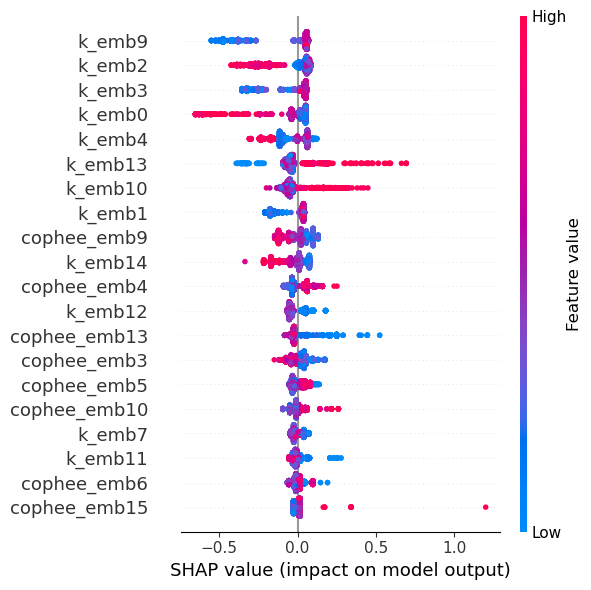

In [307]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)
plt_shap = shap.summary_plot(np.array(shap_values), #Use Shap values array
                             features=X_test, # Use training set features
                             feature_names=X_test.columns, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(6,6)) # Change plot size

In [321]:
#PSSM + CoPheeMap + KMap
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','PSSM']
for i in range(10):
    data_neg=pd.read_csv('CoPheeKSA/negative/w_feature/negative.csv',index_col=0)
    data_neg=data_neg.drop_duplicates()
    data_neg=data_neg.replace(0,np.nan)
    data_neg=data_neg[~data_neg['PSSM'].isna()]
    data_neg.index=range(len(data_neg))
    
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_train=data_train[~data_train['PSSM'].isna()]
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_neg_eval=data_neg.iloc[idx,:]
    idx2=[i for i in range(len(data_neg)) if i not in idx]
    data_neg=data_neg.iloc[idx2,:]
    
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_neg_eval=data_neg_eval[col_idx]
    data_train_neg=data_train_neg[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    #X_train=X_train.replace(np.nan,0)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_neg_eval])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_neg_eval))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)
    
    auc.append(auc_tmp)
    label.append('PSSM+CoPheeMap+KMap')

[0]	train-auc:0.87470	eval-auc:0.93528
[1]	train-auc:0.87737	eval-auc:0.93840
[2]	train-auc:0.89941	eval-auc:0.95216
[3]	train-auc:0.90091	eval-auc:0.95200
[4]	train-auc:0.90210	eval-auc:0.95240
[5]	train-auc:0.90245	eval-auc:0.95240
[6]	train-auc:0.90251	eval-auc:0.95256
[7]	train-auc:0.90668	eval-auc:0.95192
[8]	train-auc:0.90665	eval-auc:0.95208
[9]	train-auc:0.90691	eval-auc:0.95256
[10]	train-auc:0.90754	eval-auc:0.95192
[11]	train-auc:0.90790	eval-auc:0.95208
[12]	train-auc:0.91266	eval-auc:0.96256
[13]	train-auc:0.91429	eval-auc:0.96640
[14]	train-auc:0.91561	eval-auc:0.96640
[15]	train-auc:0.91706	eval-auc:0.96632
[16]	train-auc:0.91689	eval-auc:0.96616
[17]	train-auc:0.91826	eval-auc:0.96640
[18]	train-auc:0.91879	eval-auc:0.96616
[19]	train-auc:0.91919	eval-auc:0.96632
[20]	train-auc:0.91939	eval-auc:0.96600
[21]	train-auc:0.91983	eval-auc:0.96808
[22]	train-auc:0.92109	eval-auc:0.96896
[23]	train-auc:0.92148	eval-auc:0.96864
[24]	train-auc:0.92198	eval-auc:0.96896
[25]	train

Pass `evals` as keyword args.


[45]	train-auc:0.93326	eval-auc:0.97312
[46]	train-auc:0.93342	eval-auc:0.97328
[47]	train-auc:0.93367	eval-auc:0.97376
[48]	train-auc:0.93413	eval-auc:0.97360
[49]	train-auc:0.93463	eval-auc:0.97360
[50]	train-auc:0.93493	eval-auc:0.97376
[51]	train-auc:0.93513	eval-auc:0.97376
[52]	train-auc:0.93512	eval-auc:0.97360
[53]	train-auc:0.93551	eval-auc:0.97424
[54]	train-auc:0.93603	eval-auc:0.97344
[55]	train-auc:0.93615	eval-auc:0.97344
[56]	train-auc:0.93672	eval-auc:0.97344
[57]	train-auc:0.93719	eval-auc:0.97376
[58]	train-auc:0.93741	eval-auc:0.97344
[59]	train-auc:0.93752	eval-auc:0.97344
[60]	train-auc:0.93801	eval-auc:0.97360
[61]	train-auc:0.93816	eval-auc:0.97424
[62]	train-auc:0.93866	eval-auc:0.97392
0.9397257142857143
[0]	train-auc:0.87206	eval-auc:0.88344
[1]	train-auc:0.87853	eval-auc:0.89976
[2]	train-auc:0.90337	eval-auc:0.90816
[3]	train-auc:0.90465	eval-auc:0.91080
[4]	train-auc:0.90458	eval-auc:0.91080
[5]	train-auc:0.90501	eval-auc:0.91328
[6]	train-auc:0.90582	eval-

Pass `evals` as keyword args.


0.914806624483471
[0]	train-auc:0.87670	eval-auc:0.91200
[1]	train-auc:0.88041	eval-auc:0.91784
[2]	train-auc:0.90070	eval-auc:0.91688
[3]	train-auc:0.90105	eval-auc:0.91752
[4]	train-auc:0.90357	eval-auc:0.92992
[5]	train-auc:0.90441	eval-auc:0.93064
[6]	train-auc:0.90438	eval-auc:0.93064
[7]	train-auc:0.90533	eval-auc:0.93360
[8]	train-auc:0.90557	eval-auc:0.93080
[9]	train-auc:0.91090	eval-auc:0.92800
[10]	train-auc:0.91139	eval-auc:0.93120
[11]	train-auc:0.91282	eval-auc:0.93120
[12]	train-auc:0.91358	eval-auc:0.93232
[13]	train-auc:0.91394	eval-auc:0.93120
[14]	train-auc:0.91408	eval-auc:0.93088
[15]	train-auc:0.91551	eval-auc:0.93112
[16]	train-auc:0.91677	eval-auc:0.93168


Pass `evals` as keyword args.


0.897834315191844
[0]	train-auc:0.87096	eval-auc:0.85608
[1]	train-auc:0.89050	eval-auc:0.91712
[2]	train-auc:0.90142	eval-auc:0.91496
[3]	train-auc:0.90192	eval-auc:0.91384
[4]	train-auc:0.90217	eval-auc:0.91368
[5]	train-auc:0.90279	eval-auc:0.91320
[6]	train-auc:0.90588	eval-auc:0.91224
[7]	train-auc:0.90588	eval-auc:0.91224
[8]	train-auc:0.90716	eval-auc:0.92672
[9]	train-auc:0.90703	eval-auc:0.92800
[10]	train-auc:0.90742	eval-auc:0.92832
[11]	train-auc:0.91099	eval-auc:0.92584
[12]	train-auc:0.91374	eval-auc:0.92424
[13]	train-auc:0.91369	eval-auc:0.92424
[14]	train-auc:0.91552	eval-auc:0.92600
[15]	train-auc:0.91584	eval-auc:0.92520
[16]	train-auc:0.91651	eval-auc:0.92296
[17]	train-auc:0.91757	eval-auc:0.92344
[18]	train-auc:0.91803	eval-auc:0.92272
[19]	train-auc:0.91880	eval-auc:0.92376
[20]	train-auc:0.91984	eval-auc:0.92168


Pass `evals` as keyword args.


0.9239200000000001
[0]	train-auc:0.86148	eval-auc:0.86256
[1]	train-auc:0.88052	eval-auc:0.86992
[2]	train-auc:0.88146	eval-auc:0.87240
[3]	train-auc:0.90206	eval-auc:0.88928
[4]	train-auc:0.90219	eval-auc:0.89008
[5]	train-auc:0.90293	eval-auc:0.89072
[6]	train-auc:0.90282	eval-auc:0.89184
[7]	train-auc:0.90280	eval-auc:0.89216
[8]	train-auc:0.90452	eval-auc:0.89144
[9]	train-auc:0.91057	eval-auc:0.89968
[10]	train-auc:0.91063	eval-auc:0.90048
[11]	train-auc:0.91142	eval-auc:0.90168
[12]	train-auc:0.91228	eval-auc:0.90032
[13]	train-auc:0.91441	eval-auc:0.90264
[14]	train-auc:0.91477	eval-auc:0.90224
[15]	train-auc:0.91506	eval-auc:0.90256
[16]	train-auc:0.91559	eval-auc:0.90368
[17]	train-auc:0.91678	eval-auc:0.91408
[18]	train-auc:0.91715	eval-auc:0.91408
[19]	train-auc:0.91848	eval-auc:0.91640
[20]	train-auc:0.91919	eval-auc:0.92056
[21]	train-auc:0.91949	eval-auc:0.92160
[22]	train-auc:0.92041	eval-auc:0.92312
[23]	train-auc:0.92096	eval-auc:0.92256
[24]	train-auc:0.92205	eval-auc

Pass `evals` as keyword args.


[44]	train-auc:0.93234	eval-auc:0.93680
[45]	train-auc:0.93275	eval-auc:0.93792
[46]	train-auc:0.93320	eval-auc:0.93760
[47]	train-auc:0.93356	eval-auc:0.93760
[48]	train-auc:0.93388	eval-auc:0.94080
[49]	train-auc:0.93415	eval-auc:0.94320
[50]	train-auc:0.93434	eval-auc:0.94352
[51]	train-auc:0.93447	eval-auc:0.94320
[52]	train-auc:0.93488	eval-auc:0.94464
[53]	train-auc:0.93520	eval-auc:0.94592
[54]	train-auc:0.93579	eval-auc:0.94736
[55]	train-auc:0.93579	eval-auc:0.94768
[56]	train-auc:0.93648	eval-auc:0.94800
[57]	train-auc:0.93688	eval-auc:0.94848
[58]	train-auc:0.93703	eval-auc:0.94864
[59]	train-auc:0.93712	eval-auc:0.94896
[60]	train-auc:0.93717	eval-auc:0.94816
[61]	train-auc:0.93762	eval-auc:0.94848
[62]	train-auc:0.93793	eval-auc:0.94928
[63]	train-auc:0.93796	eval-auc:0.94912
[64]	train-auc:0.93804	eval-auc:0.94928
[65]	train-auc:0.93829	eval-auc:0.94880
[66]	train-auc:0.93874	eval-auc:0.94752
[67]	train-auc:0.93893	eval-auc:0.94912
[68]	train-auc:0.93925	eval-auc:0.94912


Pass `evals` as keyword args.


[46]	train-auc:0.93540	eval-auc:0.95840
[47]	train-auc:0.93551	eval-auc:0.95792
[48]	train-auc:0.93591	eval-auc:0.95792
[49]	train-auc:0.93624	eval-auc:0.95712
[50]	train-auc:0.93626	eval-auc:0.95776
[51]	train-auc:0.93661	eval-auc:0.95808
[52]	train-auc:0.93701	eval-auc:0.95824
[53]	train-auc:0.93754	eval-auc:0.95792
[54]	train-auc:0.93789	eval-auc:0.95760
[55]	train-auc:0.93825	eval-auc:0.95792
0.9236311983471075
[0]	train-auc:0.87448	eval-auc:0.91064
[1]	train-auc:0.87774	eval-auc:0.91024
[2]	train-auc:0.88329	eval-auc:0.92456
[3]	train-auc:0.89989	eval-auc:0.92328
[4]	train-auc:0.89988	eval-auc:0.92328
[5]	train-auc:0.90143	eval-auc:0.92296
[6]	train-auc:0.90143	eval-auc:0.92296
[7]	train-auc:0.90190	eval-auc:0.92328
[8]	train-auc:0.90426	eval-auc:0.92384
[9]	train-auc:0.90442	eval-auc:0.92368
[10]	train-auc:0.90469	eval-auc:0.92392
[11]	train-auc:0.90463	eval-auc:0.92392
[12]	train-auc:0.90519	eval-auc:0.92600
[13]	train-auc:0.90768	eval-auc:0.93792
[14]	train-auc:0.90865	eval-auc

Pass `evals` as keyword args.


0.9321277579601004
[0]	train-auc:0.88009	eval-auc:0.88400
[1]	train-auc:0.88453	eval-auc:0.89160
[2]	train-auc:0.89918	eval-auc:0.90912
[3]	train-auc:0.89964	eval-auc:0.91024
[4]	train-auc:0.90199	eval-auc:0.91032
[5]	train-auc:0.90231	eval-auc:0.91112
[6]	train-auc:0.90239	eval-auc:0.91064
[7]	train-auc:0.90244	eval-auc:0.91224
[8]	train-auc:0.90288	eval-auc:0.91216
[9]	train-auc:0.90469	eval-auc:0.91136
[10]	train-auc:0.90517	eval-auc:0.91104
[11]	train-auc:0.90520	eval-auc:0.91048
[12]	train-auc:0.90597	eval-auc:0.91008
[13]	train-auc:0.90601	eval-auc:0.91008
[14]	train-auc:0.90778	eval-auc:0.90864
[15]	train-auc:0.91026	eval-auc:0.90920
[16]	train-auc:0.91310	eval-auc:0.91840
[17]	train-auc:0.91463	eval-auc:0.91736
[18]	train-auc:0.91643	eval-auc:0.92704
[19]	train-auc:0.91748	eval-auc:0.93008
[20]	train-auc:0.91787	eval-auc:0.93072
[21]	train-auc:0.91886	eval-auc:0.93040
[22]	train-auc:0.91982	eval-auc:0.93048
[23]	train-auc:0.92068	eval-auc:0.93192
[24]	train-auc:0.92246	eval-auc

Pass `evals` as keyword args.


0.9458606835672249
[0]	train-auc:0.87758	eval-auc:0.88184
[1]	train-auc:0.88097	eval-auc:0.88256
[2]	train-auc:0.88511	eval-auc:0.88624
[3]	train-auc:0.90367	eval-auc:0.88136
[4]	train-auc:0.90421	eval-auc:0.88120
[5]	train-auc:0.90432	eval-auc:0.88120
[6]	train-auc:0.90441	eval-auc:0.88128
[7]	train-auc:0.90525	eval-auc:0.88128
[8]	train-auc:0.90764	eval-auc:0.87960
[9]	train-auc:0.90852	eval-auc:0.88072
[10]	train-auc:0.91051	eval-auc:0.88992
[11]	train-auc:0.91056	eval-auc:0.88992
[12]	train-auc:0.91283	eval-auc:0.88440
[13]	train-auc:0.91432	eval-auc:0.88264
[14]	train-auc:0.91597	eval-auc:0.88080
[15]	train-auc:0.91675	eval-auc:0.88248
[16]	train-auc:0.91802	eval-auc:0.88320
[17]	train-auc:0.91862	eval-auc:0.90384
[18]	train-auc:0.91885	eval-auc:0.90320
[19]	train-auc:0.91962	eval-auc:0.90600
[20]	train-auc:0.92042	eval-auc:0.90680
[21]	train-auc:0.92099	eval-auc:0.90600
[22]	train-auc:0.92258	eval-auc:0.90776
[23]	train-auc:0.92338	eval-auc:0.90512
[24]	train-auc:0.92382	eval-auc

Pass `evals` as keyword args.


[47]	train-auc:0.93375	eval-auc:0.91280
[48]	train-auc:0.93383	eval-auc:0.91328
[49]	train-auc:0.93426	eval-auc:0.91536
[50]	train-auc:0.93447	eval-auc:0.91552
[51]	train-auc:0.93469	eval-auc:0.91488
[52]	train-auc:0.93498	eval-auc:0.91552
[53]	train-auc:0.93518	eval-auc:0.91552
[54]	train-auc:0.93542	eval-auc:0.91648
[55]	train-auc:0.93573	eval-auc:0.91600
[56]	train-auc:0.93581	eval-auc:0.91632
[57]	train-auc:0.93613	eval-auc:0.91680
[58]	train-auc:0.93640	eval-auc:0.91376
[59]	train-auc:0.93653	eval-auc:0.91376
[60]	train-auc:0.93683	eval-auc:0.91312
[61]	train-auc:0.93694	eval-auc:0.91376
[62]	train-auc:0.93720	eval-auc:0.91392
[63]	train-auc:0.93760	eval-auc:0.91568
[64]	train-auc:0.93775	eval-auc:0.91504
[65]	train-auc:0.93814	eval-auc:0.91616
[66]	train-auc:0.93855	eval-auc:0.91600
0.9232793209876543
[0]	train-auc:0.87527	eval-auc:0.83720
[1]	train-auc:0.87925	eval-auc:0.84288
[2]	train-auc:0.89899	eval-auc:0.87952
[3]	train-auc:0.90000	eval-auc:0.88304
[4]	train-auc:0.90212	eva

Pass `evals` as keyword args.


[51]	train-auc:0.93423	eval-auc:0.93616
[52]	train-auc:0.93437	eval-auc:0.93696
[53]	train-auc:0.93494	eval-auc:0.93808
[54]	train-auc:0.93510	eval-auc:0.93808
[55]	train-auc:0.93529	eval-auc:0.93872
[56]	train-auc:0.93562	eval-auc:0.93824
[57]	train-auc:0.93607	eval-auc:0.93808
[58]	train-auc:0.93652	eval-auc:0.93952
[59]	train-auc:0.93667	eval-auc:0.94016
[60]	train-auc:0.93699	eval-auc:0.94064
[61]	train-auc:0.93724	eval-auc:0.94000
[62]	train-auc:0.93740	eval-auc:0.94016
[63]	train-auc:0.93746	eval-auc:0.94016
[64]	train-auc:0.93765	eval-auc:0.94016
[65]	train-auc:0.93786	eval-auc:0.94016
[66]	train-auc:0.93799	eval-auc:0.93984
[67]	train-auc:0.93871	eval-auc:0.93984
[68]	train-auc:0.93878	eval-auc:0.93968
[69]	train-auc:0.93910	eval-auc:0.94000
0.9320854969206618


In [322]:
#Dynamic features
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s']
for i in range(10):
    data_neg=pd.read_csv('CoPheeKSA/negative/w_feature/negative.csv',index_col=0)
    data_neg=data_neg.drop_duplicates()
    data_neg=data_neg.replace(0,np.nan)
    data_neg=data_neg[~data_neg['PSSM'].isna()]
    data_neg.index=range(len(data_neg))
    
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    #Avoid overfitting caused by missing values
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
        
        c=tmp[['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']].isna().sum()
        for idx_col in ['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']:
            num=int(c.loc[idx_col]/len(tmp)*len(tmp2))
            idx=random.sample(tmp2.index.tolist(),num)
            
            for z in idx:
                tmp2.loc[z, idx_col]=np.nan
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    #data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_neg_eval=data_neg.iloc[idx,:]
    idx2=[i for i in range(len(data_neg)) if i not in idx]
    data_neg=data_neg.iloc[idx2,:]
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_neg_eval=data_neg_eval[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_neg_eval])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_neg_eval))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)
    
    auc.append(auc_tmp)
    label.append('Dynamic_features')

[0]	train-auc:0.58615	eval-auc:0.68064
[1]	train-auc:0.63075	eval-auc:0.75472
[2]	train-auc:0.65275	eval-auc:0.80696
[3]	train-auc:0.65510	eval-auc:0.80512
[4]	train-auc:0.65732	eval-auc:0.80168
[5]	train-auc:0.66846	eval-auc:0.84024
[6]	train-auc:0.67576	eval-auc:0.83376
[7]	train-auc:0.68488	eval-auc:0.84976
[8]	train-auc:0.69012	eval-auc:0.84432
[9]	train-auc:0.69561	eval-auc:0.85448
[10]	train-auc:0.70098	eval-auc:0.84816
[11]	train-auc:0.70976	eval-auc:0.86960
[12]	train-auc:0.71800	eval-auc:0.87144
[13]	train-auc:0.72075	eval-auc:0.86672
[14]	train-auc:0.72462	eval-auc:0.87808
[15]	train-auc:0.72943	eval-auc:0.88088
[16]	train-auc:0.73294	eval-auc:0.87984
[17]	train-auc:0.73884	eval-auc:0.88656
[18]	train-auc:0.74151	eval-auc:0.89352
[19]	train-auc:0.74373	eval-auc:0.88968
[20]	train-auc:0.74688	eval-auc:0.89304
[21]	train-auc:0.74896	eval-auc:0.89960
[22]	train-auc:0.75011	eval-auc:0.90056
[23]	train-auc:0.75136	eval-auc:0.89672
[24]	train-auc:0.75339	eval-auc:0.89928
[25]	train

Pass `evals` as keyword args.


[30]	train-auc:0.76363	eval-auc:0.88568
[31]	train-auc:0.76426	eval-auc:0.88920
0.8039036734693877
[0]	train-auc:0.60357	eval-auc:0.68480
[1]	train-auc:0.61059	eval-auc:0.67952
[2]	train-auc:0.64975	eval-auc:0.68160
[3]	train-auc:0.65909	eval-auc:0.69528
[4]	train-auc:0.65750	eval-auc:0.70744
[5]	train-auc:0.66247	eval-auc:0.70880
[6]	train-auc:0.66721	eval-auc:0.72304
[7]	train-auc:0.67579	eval-auc:0.71704
[8]	train-auc:0.68506	eval-auc:0.73864
[9]	train-auc:0.68525	eval-auc:0.73968
[10]	train-auc:0.69455	eval-auc:0.76440
[11]	train-auc:0.70149	eval-auc:0.78192
[12]	train-auc:0.70880	eval-auc:0.78256
[13]	train-auc:0.71928	eval-auc:0.77912
[14]	train-auc:0.72337	eval-auc:0.78040
[15]	train-auc:0.72755	eval-auc:0.78312
[16]	train-auc:0.72836	eval-auc:0.78224
[17]	train-auc:0.73855	eval-auc:0.78120
[18]	train-auc:0.74004	eval-auc:0.79232
[19]	train-auc:0.74360	eval-auc:0.78928
[20]	train-auc:0.74878	eval-auc:0.77552
[21]	train-auc:0.74934	eval-auc:0.77584
[22]	train-auc:0.75120	eval-auc

Pass `evals` as keyword args.


0.8252953899793388
[0]	train-auc:0.56223	eval-auc:0.57120
[1]	train-auc:0.63199	eval-auc:0.56832
[2]	train-auc:0.66073	eval-auc:0.69136
[3]	train-auc:0.66397	eval-auc:0.67616
[4]	train-auc:0.66288	eval-auc:0.63352
[5]	train-auc:0.66932	eval-auc:0.60680
[6]	train-auc:0.67378	eval-auc:0.64280
[7]	train-auc:0.68254	eval-auc:0.66944
[8]	train-auc:0.68984	eval-auc:0.66704
[9]	train-auc:0.69665	eval-auc:0.66248
[10]	train-auc:0.70505	eval-auc:0.67576
[11]	train-auc:0.70981	eval-auc:0.66928


Pass `evals` as keyword args.


0.7158328500351028
[0]	train-auc:0.55985	eval-auc:0.56104
[1]	train-auc:0.60341	eval-auc:0.63688
[2]	train-auc:0.63521	eval-auc:0.66832
[3]	train-auc:0.65141	eval-auc:0.66816
[4]	train-auc:0.66700	eval-auc:0.70040
[5]	train-auc:0.66545	eval-auc:0.69872
[6]	train-auc:0.67840	eval-auc:0.71984
[7]	train-auc:0.68252	eval-auc:0.73048
[8]	train-auc:0.68509	eval-auc:0.71880
[9]	train-auc:0.68464	eval-auc:0.71576
[10]	train-auc:0.69073	eval-auc:0.73032
[11]	train-auc:0.69939	eval-auc:0.73848
[12]	train-auc:0.70948	eval-auc:0.75568
[13]	train-auc:0.71294	eval-auc:0.76368
[14]	train-auc:0.71860	eval-auc:0.76072
[15]	train-auc:0.72261	eval-auc:0.77240
[16]	train-auc:0.72629	eval-auc:0.77496
[17]	train-auc:0.73100	eval-auc:0.78896
[18]	train-auc:0.73281	eval-auc:0.79544
[19]	train-auc:0.73416	eval-auc:0.79584
[20]	train-auc:0.73889	eval-auc:0.79824
[21]	train-auc:0.74156	eval-auc:0.80312
[22]	train-auc:0.74613	eval-auc:0.80360
[23]	train-auc:0.74869	eval-auc:0.80984
[24]	train-auc:0.75139	eval-auc

Pass `evals` as keyword args.


[31]	train-auc:0.76121	eval-auc:0.83488
[32]	train-auc:0.76200	eval-auc:0.83760
[33]	train-auc:0.76360	eval-auc:0.83840
[34]	train-auc:0.76614	eval-auc:0.84016
[35]	train-auc:0.76750	eval-auc:0.83936
[36]	train-auc:0.76771	eval-auc:0.83792
[37]	train-auc:0.76852	eval-auc:0.83856
[38]	train-auc:0.77016	eval-auc:0.84256
[39]	train-auc:0.77234	eval-auc:0.84656
[40]	train-auc:0.77353	eval-auc:0.84208
[41]	train-auc:0.77442	eval-auc:0.84416
[42]	train-auc:0.77505	eval-auc:0.84496
[43]	train-auc:0.77634	eval-auc:0.84208
[44]	train-auc:0.77799	eval-auc:0.84000
[45]	train-auc:0.77854	eval-auc:0.84064
[46]	train-auc:0.77890	eval-auc:0.84064
[47]	train-auc:0.77957	eval-auc:0.84112
[48]	train-auc:0.77942	eval-auc:0.84160
0.8406122448979592
[0]	train-auc:0.55579	eval-auc:0.59928
[1]	train-auc:0.61461	eval-auc:0.69992
[2]	train-auc:0.65162	eval-auc:0.71376
[3]	train-auc:0.65468	eval-auc:0.71984
[4]	train-auc:0.65569	eval-auc:0.71392
[5]	train-auc:0.67006	eval-auc:0.73048
[6]	train-auc:0.67811	eval-

Pass `evals` as keyword args.


[32]	train-auc:0.76306	eval-auc:0.78696
[33]	train-auc:0.76429	eval-auc:0.78792
[34]	train-auc:0.76610	eval-auc:0.79000
[35]	train-auc:0.76783	eval-auc:0.78560
[36]	train-auc:0.76942	eval-auc:0.78368
[37]	train-auc:0.77104	eval-auc:0.78816
[38]	train-auc:0.77236	eval-auc:0.78656
[39]	train-auc:0.77210	eval-auc:0.78288
0.8077469135802469
[0]	train-auc:0.61142	eval-auc:0.60936
[1]	train-auc:0.63388	eval-auc:0.63048
[2]	train-auc:0.64247	eval-auc:0.62312
[3]	train-auc:0.66173	eval-auc:0.67096
[4]	train-auc:0.67370	eval-auc:0.71568
[5]	train-auc:0.67608	eval-auc:0.70552
[6]	train-auc:0.68047	eval-auc:0.72848
[7]	train-auc:0.68429	eval-auc:0.74496
[8]	train-auc:0.69184	eval-auc:0.74688
[9]	train-auc:0.69774	eval-auc:0.75664
[10]	train-auc:0.70021	eval-auc:0.76168
[11]	train-auc:0.70452	eval-auc:0.77064
[12]	train-auc:0.70782	eval-auc:0.75952
[13]	train-auc:0.71499	eval-auc:0.75984
[14]	train-auc:0.72236	eval-auc:0.77848
[15]	train-auc:0.72905	eval-auc:0.77440
[16]	train-auc:0.72956	eval-auc

Pass `evals` as keyword args.


[32]	train-auc:0.76142	eval-auc:0.80304
[33]	train-auc:0.76330	eval-auc:0.80240
[34]	train-auc:0.76429	eval-auc:0.80184
[35]	train-auc:0.76542	eval-auc:0.80440
[36]	train-auc:0.76717	eval-auc:0.80728
[37]	train-auc:0.76832	eval-auc:0.80344
[38]	train-auc:0.76852	eval-auc:0.80408
0.804256521177686
[0]	train-auc:0.60230	eval-auc:0.57408
[1]	train-auc:0.62692	eval-auc:0.65968
[2]	train-auc:0.65331	eval-auc:0.72824
[3]	train-auc:0.66266	eval-auc:0.68592
[4]	train-auc:0.66685	eval-auc:0.70096
[5]	train-auc:0.67171	eval-auc:0.70352
[6]	train-auc:0.67800	eval-auc:0.69488
[7]	train-auc:0.68466	eval-auc:0.71064
[8]	train-auc:0.68868	eval-auc:0.70984
[9]	train-auc:0.69191	eval-auc:0.72368
[10]	train-auc:0.69643	eval-auc:0.74216
[11]	train-auc:0.70468	eval-auc:0.75568
[12]	train-auc:0.71460	eval-auc:0.76168
[13]	train-auc:0.71549	eval-auc:0.76312
[14]	train-auc:0.72068	eval-auc:0.77080
[15]	train-auc:0.72707	eval-auc:0.79088
[16]	train-auc:0.72769	eval-auc:0.79760
[17]	train-auc:0.72909	eval-auc:

Pass `evals` as keyword args.


[31]	train-auc:0.76169	eval-auc:0.81032
0.7967168714493329
[0]	train-auc:0.55936	eval-auc:0.57912
[1]	train-auc:0.59336	eval-auc:0.62392
[2]	train-auc:0.63135	eval-auc:0.66720
[3]	train-auc:0.65686	eval-auc:0.72592
[4]	train-auc:0.65734	eval-auc:0.71512
[5]	train-auc:0.65677	eval-auc:0.70808
[6]	train-auc:0.66557	eval-auc:0.66936
[7]	train-auc:0.67513	eval-auc:0.70576
[8]	train-auc:0.67786	eval-auc:0.71480
[9]	train-auc:0.69526	eval-auc:0.74440
[10]	train-auc:0.69832	eval-auc:0.75768
[11]	train-auc:0.70364	eval-auc:0.75296
[12]	train-auc:0.71418	eval-auc:0.77560
[13]	train-auc:0.71875	eval-auc:0.77504
[14]	train-auc:0.72457	eval-auc:0.78376
[15]	train-auc:0.72920	eval-auc:0.79448
[16]	train-auc:0.73249	eval-auc:0.79216
[17]	train-auc:0.73639	eval-auc:0.79728
[18]	train-auc:0.74054	eval-auc:0.79472
[19]	train-auc:0.74241	eval-auc:0.79648
[20]	train-auc:0.74261	eval-auc:0.79064
[21]	train-auc:0.74552	eval-auc:0.78632
[22]	train-auc:0.74770	eval-auc:0.79320
[23]	train-auc:0.74890	eval-auc

Pass `evals` as keyword args.


[31]	train-auc:0.76214	eval-auc:0.80752
[32]	train-auc:0.76271	eval-auc:0.81072
[33]	train-auc:0.76462	eval-auc:0.81376
[34]	train-auc:0.76571	eval-auc:0.81984
[35]	train-auc:0.76711	eval-auc:0.81824
[36]	train-auc:0.76784	eval-auc:0.81568
[37]	train-auc:0.76969	eval-auc:0.81472
[38]	train-auc:0.77014	eval-auc:0.81840
[39]	train-auc:0.77143	eval-auc:0.81664
[40]	train-auc:0.77327	eval-auc:0.81104
[41]	train-auc:0.77463	eval-auc:0.81296
[42]	train-auc:0.77564	eval-auc:0.81456
[43]	train-auc:0.77588	eval-auc:0.81456
[44]	train-auc:0.77642	eval-auc:0.82080
[45]	train-auc:0.77695	eval-auc:0.81920
[46]	train-auc:0.77724	eval-auc:0.82016
[47]	train-auc:0.77736	eval-auc:0.81600
[48]	train-auc:0.77846	eval-auc:0.81664
[49]	train-auc:0.78102	eval-auc:0.81328
[50]	train-auc:0.78219	eval-auc:0.81776
[51]	train-auc:0.78259	eval-auc:0.81808
[52]	train-auc:0.78294	eval-auc:0.82016
[53]	train-auc:0.78300	eval-auc:0.82256
[54]	train-auc:0.78379	eval-auc:0.82336
[55]	train-auc:0.78436	eval-auc:0.82416


Pass `evals` as keyword args.


0.7814398148148148
[0]	train-auc:0.58227	eval-auc:0.48904
[1]	train-auc:0.62403	eval-auc:0.51480
[2]	train-auc:0.65257	eval-auc:0.64080
[3]	train-auc:0.66419	eval-auc:0.52848
[4]	train-auc:0.66118	eval-auc:0.49968
[5]	train-auc:0.67464	eval-auc:0.59584
[6]	train-auc:0.68255	eval-auc:0.64600
[7]	train-auc:0.68815	eval-auc:0.63616
[8]	train-auc:0.68932	eval-auc:0.66352
[9]	train-auc:0.69595	eval-auc:0.64744
[10]	train-auc:0.70512	eval-auc:0.66032
[11]	train-auc:0.71638	eval-auc:0.69264
[12]	train-auc:0.72286	eval-auc:0.70224
[13]	train-auc:0.72510	eval-auc:0.70168
[14]	train-auc:0.73031	eval-auc:0.70816
[15]	train-auc:0.72895	eval-auc:0.68808
[16]	train-auc:0.73429	eval-auc:0.69984
[17]	train-auc:0.73597	eval-auc:0.70464
[18]	train-auc:0.73997	eval-auc:0.70360
[19]	train-auc:0.74383	eval-auc:0.71464
[20]	train-auc:0.74601	eval-auc:0.71544
[21]	train-auc:0.74770	eval-auc:0.72112
[22]	train-auc:0.75033	eval-auc:0.72832
[23]	train-auc:0.75376	eval-auc:0.73200
[24]	train-auc:0.75506	eval-auc

Pass `evals` as keyword args.


[32]	train-auc:0.76562	eval-auc:0.75960
[33]	train-auc:0.76816	eval-auc:0.75144
[34]	train-auc:0.76887	eval-auc:0.75336
[35]	train-auc:0.76946	eval-auc:0.75544
[36]	train-auc:0.76950	eval-auc:0.75576
[37]	train-auc:0.76964	eval-auc:0.75560
[38]	train-auc:0.77078	eval-auc:0.75096
[39]	train-auc:0.77155	eval-auc:0.75496
[40]	train-auc:0.77217	eval-auc:0.75912
0.819147747856539


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


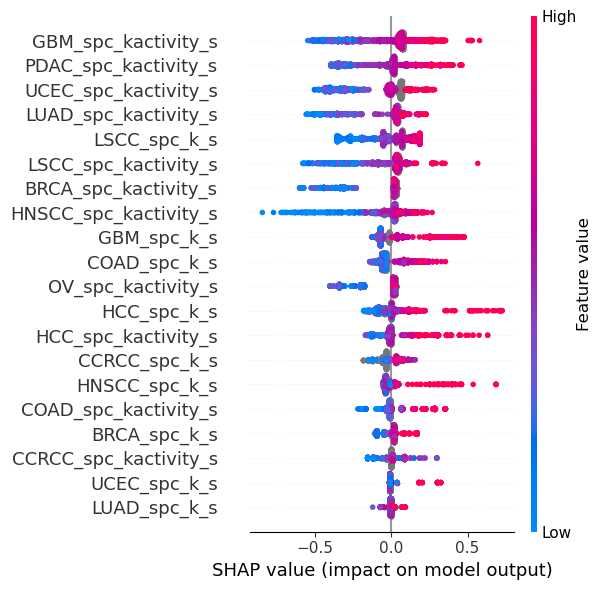

In [323]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)
plt_shap = shap.summary_plot(np.array(shap_values), #Use Shap values array
                             features=X_test, # Use training set features
                             feature_names=X_test.columns, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(6,6)) # Change plot size

In [324]:
#Dynamic features + CoPheeMap + KMap
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s']
for i in range(10):
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    #Avoid overfitting caused by missing values
    data_neg=pd.read_csv('CoPheeKSA/negative/w_feature/negative.csv',index_col=0)
    data_neg=data_neg.drop_duplicates()
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
        
        c=tmp[['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']].isna().sum()
        for idx_col in ['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']:
            num=int(c.loc[idx_col]/len(tmp)*len(tmp2))
            idx=random.sample(tmp2.index.tolist(),num)
            
            for z in idx:
                tmp2.loc[z, idx_col]=np.nan
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    #data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_neg_eval=data_neg.iloc[idx,:]
    idx2=[i for i in range(len(data_neg)) if i not in idx]
    data_neg=data_neg.iloc[idx2,:]
    
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_neg_eval=data_neg_eval[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    #X_train=X_train.replace(np.nan,0)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_neg_eval])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_neg_eval))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)
    
    auc.append(auc_tmp)
    label.append('Dynamic_features+CoPheeMap+KMap')

[0]	train-auc:0.60755	eval-auc:0.60960
[1]	train-auc:0.63182	eval-auc:0.62192
[2]	train-auc:0.65923	eval-auc:0.68528
[3]	train-auc:0.65627	eval-auc:0.67688
[4]	train-auc:0.66025	eval-auc:0.67072
[5]	train-auc:0.66436	eval-auc:0.68672
[6]	train-auc:0.67033	eval-auc:0.67344
[7]	train-auc:0.67530	eval-auc:0.67920
[8]	train-auc:0.68810	eval-auc:0.68664
[9]	train-auc:0.69655	eval-auc:0.71464
[10]	train-auc:0.70554	eval-auc:0.73032
[11]	train-auc:0.71111	eval-auc:0.73744
[12]	train-auc:0.71458	eval-auc:0.73880
[13]	train-auc:0.72106	eval-auc:0.74704
[14]	train-auc:0.72737	eval-auc:0.73696
[15]	train-auc:0.73456	eval-auc:0.74296
[16]	train-auc:0.73862	eval-auc:0.75272
[17]	train-auc:0.74126	eval-auc:0.76856
[18]	train-auc:0.74312	eval-auc:0.77064
[19]	train-auc:0.74543	eval-auc:0.77256
[20]	train-auc:0.74829	eval-auc:0.77600
[21]	train-auc:0.75046	eval-auc:0.78080
[22]	train-auc:0.75118	eval-auc:0.78288
[23]	train-auc:0.75253	eval-auc:0.77904


Pass `evals` as keyword args.


[24]	train-auc:0.75449	eval-auc:0.78272
[25]	train-auc:0.75819	eval-auc:0.77312
[26]	train-auc:0.76262	eval-auc:0.77488
[27]	train-auc:0.76507	eval-auc:0.77984
[28]	train-auc:0.76695	eval-auc:0.77824
[29]	train-auc:0.76917	eval-auc:0.78704
[30]	train-auc:0.77296	eval-auc:0.78152
[31]	train-auc:0.77333	eval-auc:0.78656
[32]	train-auc:0.77608	eval-auc:0.77968
[33]	train-auc:0.77758	eval-auc:0.77664
[34]	train-auc:0.77890	eval-auc:0.78208
[35]	train-auc:0.77995	eval-auc:0.78464
[36]	train-auc:0.78187	eval-auc:0.77760
[37]	train-auc:0.78261	eval-auc:0.77936
[38]	train-auc:0.78476	eval-auc:0.77952
0.8511036734693878
[0]	train-auc:0.60475	eval-auc:0.60592
[1]	train-auc:0.61063	eval-auc:0.63008
[2]	train-auc:0.63200	eval-auc:0.60824
[3]	train-auc:0.66440	eval-auc:0.76056
[4]	train-auc:0.66544	eval-auc:0.77864
[5]	train-auc:0.66525	eval-auc:0.76568
[6]	train-auc:0.67096	eval-auc:0.77288
[7]	train-auc:0.67832	eval-auc:0.77312
[8]	train-auc:0.68936	eval-auc:0.77120
[9]	train-auc:0.69195	eval-auc

Pass `evals` as keyword args.


[24]	train-auc:0.76589	eval-auc:0.86392
[25]	train-auc:0.76769	eval-auc:0.86664
[26]	train-auc:0.77014	eval-auc:0.87584
[27]	train-auc:0.77552	eval-auc:0.87920
[28]	train-auc:0.77600	eval-auc:0.87952
[29]	train-auc:0.77807	eval-auc:0.88048
[30]	train-auc:0.77967	eval-auc:0.88208
[31]	train-auc:0.78183	eval-auc:0.88192
[32]	train-auc:0.78268	eval-auc:0.88064
[33]	train-auc:0.78359	eval-auc:0.88064
[34]	train-auc:0.78501	eval-auc:0.88208
[35]	train-auc:0.78686	eval-auc:0.87536
[36]	train-auc:0.78825	eval-auc:0.87904
[37]	train-auc:0.78995	eval-auc:0.87888
[38]	train-auc:0.79181	eval-auc:0.87888
[39]	train-auc:0.79283	eval-auc:0.88144
[40]	train-auc:0.79328	eval-auc:0.87984
0.8443908186983472
[0]	train-auc:0.60483	eval-auc:0.61296
[1]	train-auc:0.63584	eval-auc:0.62240
[2]	train-auc:0.64095	eval-auc:0.61968
[3]	train-auc:0.64309	eval-auc:0.61728
[4]	train-auc:0.66474	eval-auc:0.68848
[5]	train-auc:0.67271	eval-auc:0.68936
[6]	train-auc:0.68411	eval-auc:0.69008
[7]	train-auc:0.69068	eval-a

Pass `evals` as keyword args.


[25]	train-auc:0.76521	eval-auc:0.75064
0.7823433350630323
[0]	train-auc:0.55973	eval-auc:0.56400
[1]	train-auc:0.60944	eval-auc:0.62280
[2]	train-auc:0.62762	eval-auc:0.68680
[3]	train-auc:0.65554	eval-auc:0.73768
[4]	train-auc:0.65815	eval-auc:0.71960
[5]	train-auc:0.67406	eval-auc:0.72856
[6]	train-auc:0.67779	eval-auc:0.72712
[7]	train-auc:0.68076	eval-auc:0.69920
[8]	train-auc:0.68513	eval-auc:0.70448
[9]	train-auc:0.69366	eval-auc:0.73192
[10]	train-auc:0.70012	eval-auc:0.75768
[11]	train-auc:0.70225	eval-auc:0.74968
[12]	train-auc:0.71275	eval-auc:0.76776
[13]	train-auc:0.72334	eval-auc:0.79240
[14]	train-auc:0.72628	eval-auc:0.77904
[15]	train-auc:0.73163	eval-auc:0.78928
[16]	train-auc:0.73855	eval-auc:0.80768
[17]	train-auc:0.74319	eval-auc:0.81064
[18]	train-auc:0.74446	eval-auc:0.80488
[19]	train-auc:0.75024	eval-auc:0.81784
[20]	train-auc:0.75398	eval-auc:0.81496
[21]	train-auc:0.75734	eval-auc:0.82208
[22]	train-auc:0.75907	eval-auc:0.82496
[23]	train-auc:0.75979	eval-auc

Pass `evals` as keyword args.


[25]	train-auc:0.76292	eval-auc:0.83776
[26]	train-auc:0.76538	eval-auc:0.83856
[27]	train-auc:0.76734	eval-auc:0.83824
[28]	train-auc:0.76921	eval-auc:0.84304
[29]	train-auc:0.77066	eval-auc:0.84544
[30]	train-auc:0.77303	eval-auc:0.85296
[31]	train-auc:0.77413	eval-auc:0.85872
[32]	train-auc:0.77647	eval-auc:0.86272
[33]	train-auc:0.78064	eval-auc:0.86304
[34]	train-auc:0.78208	eval-auc:0.86272
[35]	train-auc:0.78298	eval-auc:0.86736
[36]	train-auc:0.78350	eval-auc:0.86448
[37]	train-auc:0.78418	eval-auc:0.86512
[38]	train-auc:0.78653	eval-auc:0.87152
[39]	train-auc:0.78703	eval-auc:0.87120
[40]	train-auc:0.78946	eval-auc:0.87088
[41]	train-auc:0.79020	eval-auc:0.87352
[42]	train-auc:0.79095	eval-auc:0.87368
[43]	train-auc:0.79281	eval-auc:0.87656
[44]	train-auc:0.79469	eval-auc:0.87728
[45]	train-auc:0.79536	eval-auc:0.87760
[46]	train-auc:0.79670	eval-auc:0.87776
[47]	train-auc:0.79808	eval-auc:0.87728
[48]	train-auc:0.79907	eval-auc:0.88064
[49]	train-auc:0.80038	eval-auc:0.88064


Pass `evals` as keyword args.


[26]	train-auc:0.76358	eval-auc:0.84432
[27]	train-auc:0.76423	eval-auc:0.85248
[28]	train-auc:0.76582	eval-auc:0.85624
[29]	train-auc:0.76732	eval-auc:0.85768
[30]	train-auc:0.77217	eval-auc:0.85976
[31]	train-auc:0.77548	eval-auc:0.86440
[32]	train-auc:0.77770	eval-auc:0.86936
[33]	train-auc:0.77978	eval-auc:0.87384
[34]	train-auc:0.78025	eval-auc:0.87128
[35]	train-auc:0.78252	eval-auc:0.87712
[36]	train-auc:0.78432	eval-auc:0.87504
[37]	train-auc:0.78579	eval-auc:0.87920
[38]	train-auc:0.78686	eval-auc:0.87120
[39]	train-auc:0.78815	eval-auc:0.87216
[40]	train-auc:0.79033	eval-auc:0.87792
[41]	train-auc:0.79118	eval-auc:0.87792
[42]	train-auc:0.79193	eval-auc:0.88256
[43]	train-auc:0.79318	eval-auc:0.88336
[44]	train-auc:0.79377	eval-auc:0.88528
[45]	train-auc:0.79455	eval-auc:0.88464
[46]	train-auc:0.79714	eval-auc:0.88384
[47]	train-auc:0.79752	eval-auc:0.88080
[48]	train-auc:0.79838	eval-auc:0.88192
[49]	train-auc:0.79916	eval-auc:0.88240
[50]	train-auc:0.79920	eval-auc:0.88128


Pass `evals` as keyword args.


[23]	train-auc:0.76280	eval-auc:0.85520
[24]	train-auc:0.76744	eval-auc:0.83688
[25]	train-auc:0.76920	eval-auc:0.83424
[26]	train-auc:0.77044	eval-auc:0.83520
[27]	train-auc:0.77016	eval-auc:0.83664
[28]	train-auc:0.77248	eval-auc:0.83776
[29]	train-auc:0.77399	eval-auc:0.83992
[30]	train-auc:0.77575	eval-auc:0.84360
[31]	train-auc:0.77703	eval-auc:0.85072
[32]	train-auc:0.77991	eval-auc:0.85472
[33]	train-auc:0.78238	eval-auc:0.86512
[34]	train-auc:0.78318	eval-auc:0.86448
[35]	train-auc:0.78595	eval-auc:0.85432
[36]	train-auc:0.79096	eval-auc:0.85024
[37]	train-auc:0.79213	eval-auc:0.84992
[38]	train-auc:0.79304	eval-auc:0.85136
[39]	train-auc:0.79368	eval-auc:0.85456
[40]	train-auc:0.79514	eval-auc:0.85744
[41]	train-auc:0.79589	eval-auc:0.84800
[42]	train-auc:0.79678	eval-auc:0.85088
[43]	train-auc:0.79753	eval-auc:0.85232
0.8411915676652894
[0]	train-auc:0.59943	eval-auc:0.58584
[1]	train-auc:0.63937	eval-auc:0.65200
[2]	train-auc:0.65131	eval-auc:0.65224
[3]	train-auc:0.65227	ev

Pass `evals` as keyword args.


[26]	train-auc:0.76183	eval-auc:0.80776
[27]	train-auc:0.76304	eval-auc:0.80584
[28]	train-auc:0.76393	eval-auc:0.81112
[29]	train-auc:0.76580	eval-auc:0.81392
[30]	train-auc:0.76744	eval-auc:0.81600
[31]	train-auc:0.76964	eval-auc:0.82032
[32]	train-auc:0.77230	eval-auc:0.82672
[33]	train-auc:0.77297	eval-auc:0.82336
[34]	train-auc:0.77472	eval-auc:0.82432
[35]	train-auc:0.77559	eval-auc:0.82064
[36]	train-auc:0.77698	eval-auc:0.82016
[37]	train-auc:0.77878	eval-auc:0.81792
[38]	train-auc:0.78007	eval-auc:0.82048
[39]	train-auc:0.78124	eval-auc:0.82528
[40]	train-auc:0.78415	eval-auc:0.82544
[41]	train-auc:0.78503	eval-auc:0.82480
[42]	train-auc:0.78641	eval-auc:0.82688
[43]	train-auc:0.78881	eval-auc:0.82048
[44]	train-auc:0.79013	eval-auc:0.82048
[45]	train-auc:0.79110	eval-auc:0.82176
[46]	train-auc:0.79211	eval-auc:0.82640
[47]	train-auc:0.79362	eval-auc:0.82832
[48]	train-auc:0.79443	eval-auc:0.82624
[49]	train-auc:0.79545	eval-auc:0.82784
[50]	train-auc:0.79632	eval-auc:0.82400


Pass `evals` as keyword args.


[26]	train-auc:0.76174	eval-auc:0.82096
[27]	train-auc:0.76338	eval-auc:0.81712
[28]	train-auc:0.76708	eval-auc:0.82448
[29]	train-auc:0.76940	eval-auc:0.82256
[30]	train-auc:0.77039	eval-auc:0.82656
[31]	train-auc:0.77206	eval-auc:0.82960
[32]	train-auc:0.77466	eval-auc:0.82528
[33]	train-auc:0.77666	eval-auc:0.82960
[34]	train-auc:0.77814	eval-auc:0.82912
[35]	train-auc:0.77985	eval-auc:0.83536
[36]	train-auc:0.78093	eval-auc:0.83136
[37]	train-auc:0.78177	eval-auc:0.83088
[38]	train-auc:0.78224	eval-auc:0.82960
[39]	train-auc:0.78326	eval-auc:0.83472
[40]	train-auc:0.78695	eval-auc:0.84144
[41]	train-auc:0.78817	eval-auc:0.83968
[42]	train-auc:0.78958	eval-auc:0.83760
[43]	train-auc:0.79203	eval-auc:0.84160
[44]	train-auc:0.79299	eval-auc:0.84448
[45]	train-auc:0.79379	eval-auc:0.84224
[46]	train-auc:0.79509	eval-auc:0.83936
[47]	train-auc:0.79597	eval-auc:0.84528
[48]	train-auc:0.79759	eval-auc:0.84736
[49]	train-auc:0.79834	eval-auc:0.84816
[50]	train-auc:0.80013	eval-auc:0.84768


Pass `evals` as keyword args.


[27]	train-auc:0.76592	eval-auc:0.71432
[28]	train-auc:0.76721	eval-auc:0.71864
[29]	train-auc:0.76867	eval-auc:0.71352
[30]	train-auc:0.77327	eval-auc:0.71112
[31]	train-auc:0.77526	eval-auc:0.71352
[32]	train-auc:0.77796	eval-auc:0.71152
[33]	train-auc:0.78058	eval-auc:0.71584
0.82441512345679
[0]	train-auc:0.61237	eval-auc:0.54240
[1]	train-auc:0.63484	eval-auc:0.61664
[2]	train-auc:0.66006	eval-auc:0.69040
[3]	train-auc:0.66054	eval-auc:0.64888
[4]	train-auc:0.66526	eval-auc:0.65544
[5]	train-auc:0.67134	eval-auc:0.68824
[6]	train-auc:0.67985	eval-auc:0.69616
[7]	train-auc:0.68589	eval-auc:0.67144
[8]	train-auc:0.69089	eval-auc:0.70848
[9]	train-auc:0.69357	eval-auc:0.69608
[10]	train-auc:0.70929	eval-auc:0.72408
[11]	train-auc:0.71461	eval-auc:0.73176
[12]	train-auc:0.72369	eval-auc:0.74096
[13]	train-auc:0.73015	eval-auc:0.77504
[14]	train-auc:0.73517	eval-auc:0.79256
[15]	train-auc:0.73807	eval-auc:0.78872
[16]	train-auc:0.74539	eval-auc:0.80304
[17]	train-auc:0.75077	eval-auc:0

Pass `evals` as keyword args.


[27]	train-auc:0.77395	eval-auc:0.79808
[28]	train-auc:0.77718	eval-auc:0.79712
[29]	train-auc:0.77801	eval-auc:0.79648
[30]	train-auc:0.77965	eval-auc:0.79760
[31]	train-auc:0.78135	eval-auc:0.79152
[32]	train-auc:0.78233	eval-auc:0.79600
[33]	train-auc:0.78542	eval-auc:0.80288
[34]	train-auc:0.78658	eval-auc:0.79536
0.8131113392102401


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


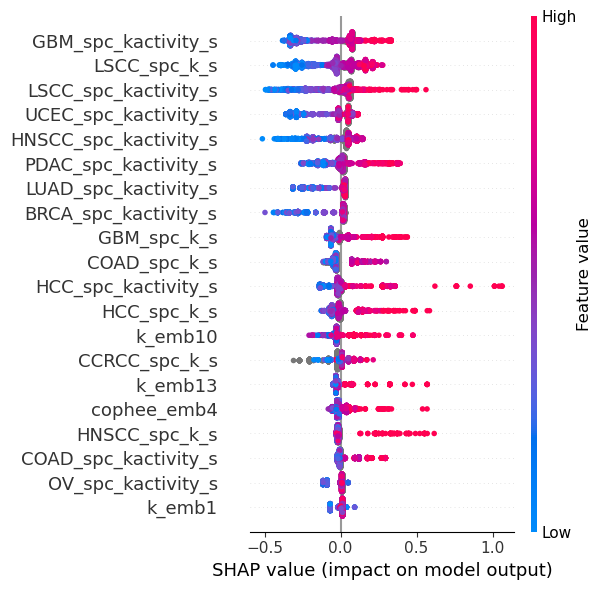

In [325]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)
plt_shap = shap.summary_plot(np.array(shap_values), #Use Shap values array
                             features=X_test, # Use training set features
                             feature_names=X_test.columns, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(6,6)) # Change plot size

In [326]:
auc_results={}
auc_results['label']=np.array(label)
auc_results['AUROC']=np.array(auc)
auc_results=pd.DataFrame(auc_results)

In [330]:
#auc_results.to_csv('CoPheeKSA/auc_results_8_9.csv')

In [327]:
tmp=pd.concat([auc_results[auc_results['label']=='PSSM'],
               auc_results[auc_results['label']=='CoPheeMap+KMap'],
               auc_results[auc_results['label']=='PSSM+CoPheeMap+KMap'],
               auc_results[auc_results['label']=='Dynamic_features'],
               auc_results[auc_results['label']=='Dynamic_features+CoPheeMap+KMap'],
               auc_results[auc_results['label']=='CoPheeKSA']])

In [328]:
set(auc_results.label)

{'CoPheeKSA',
 'CoPheeMap+KMap',
 'Dynamic_features',
 'Dynamic_features+CoPheeMap+KMap',
 'PSSM',
 'PSSM+CoPheeMap+KMap'}

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dynamic_features v.s. Dynamic_features+CoPheeMap+KMap: t-test independent samples with Bonferroni correction, P_val=6.786e-02 stat=-2.631e+00
Dynamic_features+CoPheeMap+KMap v.s. CoPheeKSA: t-test independent samples with Bonferroni correction, P_val=3.026e-10 stat=-1.348e+01
PSSM v.s. PSSM+CoPheeMap+KMap: t-test independent samples with Bonferroni correction, P_val=6.725e-03 stat=-3.688e+00
PSSM+CoPheeMap+KMap v.s. CoPheeKSA: t-test independent samples with Bonferroni correction, P_val=5.760e-04 stat=-4.798e+00


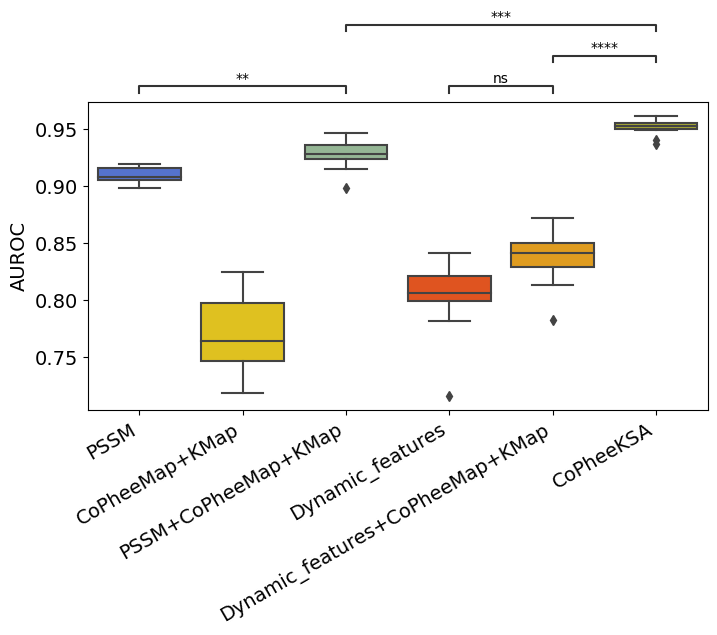

In [331]:
plt.figure(figsize=(8, 4))
x = "label"
y = "AUROC"
#hue = "label"
ax = sns.boxplot(data=tmp, x=x, y=y,palette=['royalblue','gold','darkseagreen','orangered','orange']+[sns.color_palette()[8]])
add_stat_annotation(ax, data=tmp, x=x, y=y,
                    box_pairs=[('PSSM', 'PSSM+CoPheeMap+KMap'),
                               ('Dynamic_features','Dynamic_features+CoPheeMap+KMap'),
                               ('PSSM+CoPheeMap+KMap','CoPheeKSA'),
                               ('Dynamic_features+CoPheeMap+KMap','CoPheeKSA')],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xticks(rotation=30,size=14,ha='right')
plt.yticks(size=14)
#plt.title('PSSM zscores',size=14)
plt.xlabel('')
plt.ylabel('AUROC',size=14)
#plt.legend(['PSSM','CoPheeMap+KMap','PSSM+CoPheeMap+KMap','Dynamic features','Dynamic features+CoPheeMap+KMap',
#            'CoPheeKSA'],loc='upper left', bbox_to_anchor=(1.03, 1),fontsize=12)
plt.savefig('CoPheeKSA/figures/8_9/comparision_auroc_KSA.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,orientation='portrait')
plt.show()

In [332]:
#Dynamic features + PSSM + CoPheeMap + KMap
Cancer=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC'] 
col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s','PSSM']
for i in random.sample(range(10),1):
    data_train=pd.read_csv('CoPheeKSA/train/w_feature/train_'+str(i)+'.csv',index_col=0)
    data_train=data_train.drop_duplicates()
    data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_train=data_train[~data_train['PSSM'].isna()]
    
    data_neg=pd.read_csv('CoPheeKSA/negative/w_feature/negative.csv',index_col=0)
    data_neg=data_neg.drop_duplicates()
    data_neg.index=range(len(data_neg))
    
    kinases=list(set(data_train.kinase))
    data_train_neg=pd.DataFrame()
    for k in kinases:
        tmp=data_train[data_train.kinase==k]
        tmp2=data_neg[data_neg.kinase==k]
        if len(tmp2) > 10*len(tmp):
            idx=random.sample(range(len(tmp2)),10*len(tmp))
            tmp2=tmp2.iloc[idx]
        
        c=tmp[['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']].isna().sum()
        for idx_col in ['BRCA_spc_kactivity_s',
             'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
             'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
             'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
             'UCEC_spc_kactivity_s']:
            num=int(c.loc[idx_col]/len(tmp)*len(tmp2))
            idx=random.sample(tmp2.index.tolist(),num)
            
            for z in idx:
                tmp2.loc[z, idx_col]=np.nan
            
        data_train_neg=pd.concat([data_train_neg,tmp2])
    idx=random.sample(range(len(data_neg)),2*len(data_train))
    data_train_neg=pd.concat([data_train_neg,data_neg.iloc[idx]])
    data_train_neg=data_train_neg.drop_duplicates()
    
    idx_removed=data_train_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    data_test=pd.read_csv('CoPheeKSA/test/w_feature/test_'+str(i)+'.csv',index_col=0)
    data_test=data_test.drop_duplicates()
    data_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_test=data_test[~data_test['PSSM'].isna()]
    
    idx=random.sample(range(len(data_test)),25)
    data_eval=data_test.iloc[idx,:]
    idx2=[i for i in range(len(data_test)) if i not in idx]
    data_test=data_test.iloc[idx2,:]
    
    idx=random.sample(range(len(data_neg)),10*len(data_eval))
    data_eval_neg=data_neg.iloc[idx]
    idx_removed=data_eval_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    data_neg.index=range(len(data_neg))
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_test_neg=data_neg.iloc[idx]
    idx_removed=data_test_neg.index
    data_neg=data_neg[~data_neg.index.isin(idx_removed)]
    
    data_train=data_train[col_idx]
    data_eval=data_eval[col_idx]
    data_test=data_test[col_idx]
    data_neg=data_neg[col_idx]
    data_train_neg=data_train_neg[col_idx]
    data_eval_neg=data_eval_neg[col_idx]
    
    X_train=pd.concat([data_train,data_train_neg])
    y_train=np.concatenate((np.repeat(1,len(data_train)),np.repeat(0,len(data_train_neg))))
    X_train=X_train[col_idx]
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    X_eval=pd.concat([data_eval,data_eval_neg])
    y_eval=np.concatenate((np.repeat(1,len(data_eval)),np.repeat(0,len(data_eval_neg))))
    X_eval=X_eval[col_idx]
    X_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
    deval = xgb.DMatrix(X_eval,label=y_eval)
    param = {'max_depth': 2, 'eta': 0.2, 'objective': 'binary:logistic','verbosity':0}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtrain, 'train'),(deval, 'eval')]
    num_round = 300
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    bst.save_model('CoPheeKSA/model/best_xgboost.model')
    
    idx=random.sample(range(len(data_neg)),10*len(data_test))
    data_neg2=data_neg.iloc[idx,:]
    X_test=pd.concat([data_test,data_neg2])
    X_test=X_test[col_idx]
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = bst.predict(dtest)

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc_tmp=metrics.auc(fpr, tpr)
    print(auc_tmp)

[0]	train-auc:0.87802	eval-auc:0.88560
[1]	train-auc:0.88141	eval-auc:0.88400
[2]	train-auc:0.89189	eval-auc:0.90080
[3]	train-auc:0.89877	eval-auc:0.90272
[4]	train-auc:0.89865	eval-auc:0.90168
[5]	train-auc:0.90154	eval-auc:0.91376
[6]	train-auc:0.90182	eval-auc:0.91480
[7]	train-auc:0.90244	eval-auc:0.91744
[8]	train-auc:0.90297	eval-auc:0.91696
[9]	train-auc:0.90458	eval-auc:0.91744
[10]	train-auc:0.90615	eval-auc:0.91704
[11]	train-auc:0.90972	eval-auc:0.91648
[12]	train-auc:0.91130	eval-auc:0.91336
[13]	train-auc:0.91121	eval-auc:0.91288
[14]	train-auc:0.91177	eval-auc:0.91320
[15]	train-auc:0.91367	eval-auc:0.91912
[16]	train-auc:0.91639	eval-auc:0.93312
[17]	train-auc:0.91722	eval-auc:0.93272
[18]	train-auc:0.91852	eval-auc:0.92976
[19]	train-auc:0.92137	eval-auc:0.93216
[20]	train-auc:0.92185	eval-auc:0.93392
[21]	train-auc:0.92300	eval-auc:0.93368
[22]	train-auc:0.92416	eval-auc:0.93504
[23]	train-auc:0.92500	eval-auc:0.93376
[24]	train-auc:0.92603	eval-auc:0.93552
[25]	train

Pass `evals` as keyword args.


[26]	train-auc:0.92743	eval-auc:0.93600
[27]	train-auc:0.92800	eval-auc:0.93728
[28]	train-auc:0.92872	eval-auc:0.93664
[29]	train-auc:0.92972	eval-auc:0.93664
[30]	train-auc:0.93036	eval-auc:0.93776
[31]	train-auc:0.93169	eval-auc:0.93904
[32]	train-auc:0.93193	eval-auc:0.93936
[33]	train-auc:0.93251	eval-auc:0.94080
[34]	train-auc:0.93330	eval-auc:0.94064
[35]	train-auc:0.93383	eval-auc:0.93712
[36]	train-auc:0.93406	eval-auc:0.94144
[37]	train-auc:0.93449	eval-auc:0.94432
[38]	train-auc:0.93485	eval-auc:0.94432
[39]	train-auc:0.93548	eval-auc:0.94288
[40]	train-auc:0.93608	eval-auc:0.94304
[41]	train-auc:0.93644	eval-auc:0.94160
[42]	train-auc:0.93707	eval-auc:0.94352
[43]	train-auc:0.93745	eval-auc:0.94512
[44]	train-auc:0.93768	eval-auc:0.94560
[45]	train-auc:0.93800	eval-auc:0.94544
[46]	train-auc:0.93828	eval-auc:0.94576
[47]	train-auc:0.93871	eval-auc:0.94640
[48]	train-auc:0.93926	eval-auc:0.94736
[49]	train-auc:0.93986	eval-auc:0.94880
[50]	train-auc:0.94067	eval-auc:0.94928


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


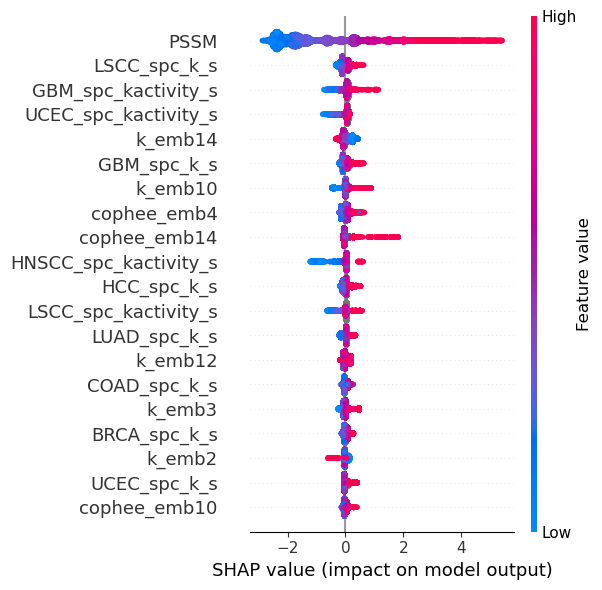

In [333]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)
plt_shap = shap.summary_plot(np.array(shap_values), #Use Shap values array
                             features=X_train, # Use training set features
                             feature_names=X_train.columns, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(6,6)) # Change plot size
# Save my figure to a directory
plt.savefig("CoPheeKSA/figures/global_shap.png")

In [334]:
idx=random.sample(range(len(data_neg)),100*len(data_test))
data_neg2=data_neg.iloc[idx,:]
X_test=pd.concat([data_test,data_neg2])
X_test=X_test[col_idx]
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
y_test=np.concatenate((np.repeat(1,len(data_test)),np.repeat(0,len(data_neg2))))
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = bst.predict(dtest)

In [335]:
y_test=pd.DataFrame(y_test)

In [336]:
#X_test.to_csv('CoPheeKSA/model/8_9/X_test.csv')
#y_test.to_csv('CoPheeKSA/model/8_9/y_test.csv')

In [7]:
X_test=pd.read_csv('CoPheeKSA/model/8_9/X_test.csv',index_col=0)
y_test=pd.read_csv('CoPheeKSA/model/8_9/y_test.csv',index_col=0)

In [8]:
bst = xgb.Booster()
bst.load_model('CoPheeKSA/model/best_xgboost.model')

In [ ]:
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = bst.predict(dtest)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
precision, recall, thresholds = precision_recall_curve(y_test,y_pred)

plt.figure(figsize=(5,5))
lw = 2
plt.plot(
    recall,precision,
    color="darkorange",
    lw=lw
)
#plt.text(0.5,0.8,'AUPRC=0.99',size=20)
#plt.plot([0, 1], [1, 0], color="navy", lw=lw, linestyle="--")
#plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best (threshold=0.17, tpr=0.938)')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel("Recall",size=20)
plt.ylabel("Precision",size=20)
#plt.savefig('CoPheeKSA/figures/8_9/precision_recall.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,orientation='portrait')
plt.show()

In [340]:
metrics.auc(fpr, tpr)

0.9614927569035763

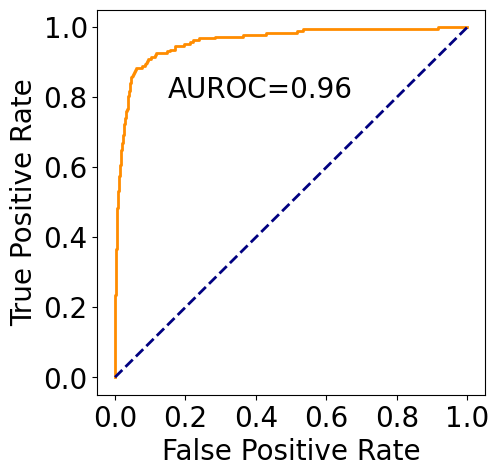

In [10]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.figure(figsize=(5,5))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
#plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best (threshold=0.17, tpr=0.938)')
plt.text(0.15,0.8,'AUROC=0.96',size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel("False Positive Rate",size=20)
plt.ylabel("True Positive Rate",size=20)
#plt.title("Receiver operating characteristic example")
#plt.legend(loc="lower right")
#plt.savefig('CoPheeKSA/figures/8_9/AUROC.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,orientation='portrait')
plt.show()

In [342]:
y_pred_100=bst.predict(dtest)

In [343]:
#Confusion matrix
#tn, fp, fn, tp 
dtest = xgb.DMatrix(X_test, label=y_test)
bgratio=y_test['0'].sum()/(len(y_test)-y_test['0'].sum())
LLR1=[]
LLR2=[]
tps=[]
fps=[]
tns=[]
fns=[]
sensi=[]
speci=[]
for i in range(len(thresholds)):
    y_pred_100 = (bst.predict(dtest) >= thresholds[i]).astype(bool)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_100).ravel()
    pos_num=tp+1
    neg_num=fp+1/bgratio
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)
    sensi.append(sensitivity)
    speci.append(specificity)
    LLR1.append(math.log(pos_num/neg_num/bgratio))
    LLR2.append(math.log(sensitivity / (1- specificity)))

invalid value encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


In [344]:
df_LLR=pd.DataFrame()
df_LLR['LLR_original']=LLR2
df_LLR['LLR_adj']=LLR1
df_LLR['threshold']=thresholds
df_LLR['tp']=tps
df_LLR['fp']=fps
df_LLR['sensitivity']=sensi
df_LLR['specificity']=speci

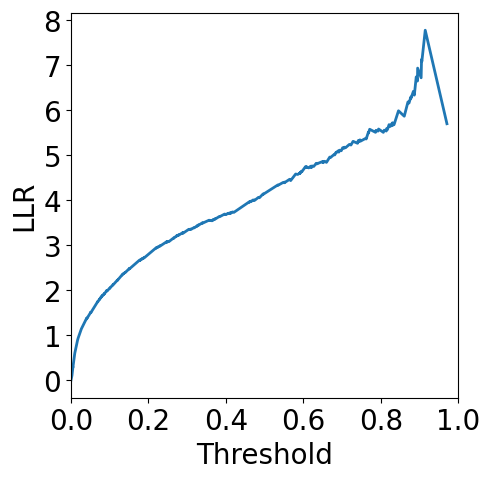

In [345]:
plt.figure(figsize=(5,5))
lw = 2
plt.plot(thresholds[:len(LLR2)],LLR2,
    lw=lw,
)
#plt.scatter(thresholds[29], LLR[29], marker='o', color='red', label='LLR=4.8, threshold=0.66')

plt.xlabel("Threshold",size=20)
plt.ylabel("LLR",size=20)
plt.xlim((0,1))
plt.xticks(size=20)
plt.yticks(size=20)
#plt.title("Receiver operating characteristic example",size=12)
#plt.legend(loc="lower right",fontsize=12)
plt.savefig('CoPheeKSA/figures/8_9/threshold_LLR.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,orientation='portrait')
plt.show()

In [228]:
#LLR>4.5
df_LLR[df_LLR['LLR_original']>=4.5]
thred_45=0.529774

In [370]:
#LLR>5
df_LLR[df_LLR['LLR_original']>=5]
thred_5=0.679686

In [371]:
#LLR>5.5
df_LLR[df_LLR['LLR_original']>=5.5]
thred_55=0.767626

In [372]:
#LLR>6
df_LLR[df_LLR['LLR_original']>=6]
thred_6=0.869822

In [373]:
#LLR>6.5
df_LLR[df_LLR['LLR_original']>=6.5]
thred_65=0.891170

In [374]:
#LLR>7
df_LLR[df_LLR['LLR_original']>=7]
thred_7=0.904875

In [ ]:
FDR=[]
dtest = xgb.DMatrix(X_test, label=y_test)
for i in range(200):
    y_pred_100 = (bst.predict(dtest) >= thresholds[i]).astype(bool)
    cm = metrics.confusion_matrix(y_test, y_pred_100)
    FP=cm[0][1]
    TP=cm[1][1]
    FDR.append(FP / (FP + TP))

In [ ]:
plt.figure(figsize=(5,5))
lw = 2
plt.plot(thresholds[:len(FDR)],FDR,
    lw=lw,
)
#plt.scatter(thresholds[30], FDR[30], marker='o', color='red', label='FDR<0.01, threshold=0.66')
plt.xlabel("Threshold",size=20)
plt.ylabel("FDR",size=20)
plt.xticks(size=18)
plt.yticks(size=20)
#plt.title("Receiver operating characteristic example",size=12)
plt.legend(loc="upper right",fontsize=12)
plt.savefig('CoPheeKSA/figures/8_9/threshold_FDR.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,orientation='portrait')
plt.show()

In [5]:
bst = xgb.Booster()
bst.load_model('CoPheeKSA/model/best_xgboost.model')
mypath='CoPheeKSA/prediction_data/without_median/'
onlyfiles = [f for f in listdir(mypath) if f!='.DS_Store']
onlyfiles = [f for f in onlyfiles if isfile(''.join([mypath, f]))]

path2='CoPheeKSA/PSSM/ST/'
onlyfiles2 = [f for f in listdir(path2) if f!='.DS_Store']
onlyfiles2 = [f for f in onlyfiles2 if 'family' not in f]
ST_k=[f.split('_')[0] for f in onlyfiles2]

In [436]:

col_idx=['cophee_emb0', 'cophee_emb1', 'cophee_emb2', 'cophee_emb3', 'cophee_emb4', 
         'cophee_emb5', 'cophee_emb6', 'cophee_emb7', 'cophee_emb8', 'cophee_emb9', 
         'cophee_emb10','cophee_emb11', 'cophee_emb12', 'cophee_emb13', 'cophee_emb14', 
         'cophee_emb15', 'k_emb0', 'k_emb1', 'k_emb2', 'k_emb3','k_emb4', 'k_emb5', 
         'k_emb6', 'k_emb7', 'k_emb8', 'k_emb9', 'k_emb10',
         'k_emb11', 'k_emb12', 'k_emb13', 'k_emb14', 'k_emb15','BRCA_spc_k_s', 
         'CCRCC_spc_k_s', 'COAD_spc_k_s', 'GBM_spc_k_s',
         'HCC_spc_k_s', 'HNSCC_spc_k_s', 'LSCC_spc_k_s', 'LUAD_spc_k_s',
         'OV_spc_k_s', 'PDAC_spc_k_s', 'UCEC_spc_k_s', 'BRCA_spc_kactivity_s',
         'CCRCC_spc_kactivity_s', 'COAD_spc_kactivity_s', 'GBM_spc_kactivity_s',
         'HCC_spc_kactivity_s', 'HNSCC_spc_kactivity_s', 'LSCC_spc_kactivity_s',
         'LUAD_spc_kactivity_s', 'OV_spc_kactivity_s', 'PDAC_spc_kactivity_s',
         'UCEC_spc_kactivity_s','PSSM']
for f in onlyfiles:
    kinase=f.split('.')[0]
    if kinase in ST_k:
        print(kinase)
        data=pd.read_csv(''.join([mypath,f]),index_col=0)
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data.index=data.sites
        score=[]
        data=data[col_idx]
        y_test=np.repeat(0,len(data))
        dtest = xgb.DMatrix(data, label=y_test)
        prediction = bst.predict(dtest)
        data['prediction']=np.array(prediction)
        data.to_csv(''.join(['CoPheeKSA/prediction/8_9/',f]))

RAF1
IKBKB
CASK
PAK3
MKNK1
PAK2
CAMK2A
LATS2
CDC7
PINK1
MAPK7
PAK1
CAMK2B
MAPK6
LATS1
DAPK1
DYRK2
PAK4
CAMK2G
MAPK3
PRKACA
PRKD2
IKBKE
DAPK2
MAPK1
MARK3
CAMK2D
MARK2
PRKD1
TBK1
DAPK3
PRKCD
RPS6KA1
ULK1
GRK5
MELK
STK3
GRK4
BUB1
PRKCE
PRKCG
NEK7
GRK6
SMG1
NEK6
TAF1
RPS6KA3
PRKCB
PKN1
AKT2
SIK2
NEK2
PDK2
TRPM7
STK4
CDK12
CLK2
AKT3
MAP3K8
WNK1
ARAF
WNK3
PRKCA
CDK9
AKT1
ILK
TTK
PDK1
NEK1
EIF2AK2
ATR
RPS6KA5
CDK8
CDK5
MTOR
PLK4
ROCK1
SRPK1
SGK3
DYRK1A
TGFBR2
CDK4
MAP3K7
PIM1
MAP3K5
CDK6
OXSR1
SGK1
ROCK2
DYRK1B
CDK7
CDK3
PLK2
CAMK4
PLK3
CHEK1
CDK2
MAP3K1
MAP3K3
NUAK1
PLK1
HIPK2
ATM
NEK9
CDK1
CHEK2
MAP3K2
LRRK2
CHUK
BRAF
MAP2K4
MAP2K6
MAPKAPK3
MAPKAPK2
MAPK15
MAP2K7
IRAK4
MAP4K1
PDPK1
STK38
GSK3B
MAP2K3
MAPK10
CSNK2A1
STK11
AURKA
MAPK8
GSK3A
CSNK2A2
MAP2K1
MAPK9


In [8]:
mypath='CoPheeKSA/prediction/8_9/'
onlyfiles = [f for f in listdir(mypath) if f!='.DS_Store']
ks1=[i.split('_')[0] for i in onlyfiles]
print(len(ks1))
combined_pos=pd.DataFrame()
for f in onlyfiles:
    print(f)
    kinase=f.split('.')[0]
    data=pd.read_csv(''.join([mypath,'/',f]),index_col=0)
    data=data.sort_values('prediction',ascending=False)
    data_pos=data[data.prediction>thred_55]
    #data_pos=data_pos.iloc[:1000]
    data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
    print(len(data_pos))
    combined_pos=pd.concat([combined_pos,data_pos])

131
RAF1.csv
19
IKBKB.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


0
CASK.csv
69
PAK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


20
MKNK1.csv
441
PAK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


0
CAMK2A.csv
0
LATS2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


43
CDC7.csv
10
PINK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


1
MAPK7.csv
423
PAK1.csv
0
CAMK2B.csv
21
MAPK6.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


29
LATS1.csv
8
DAPK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


0
DYRK2.csv
191
PAK4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


11
CAMK2G.csv
28
MAPK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


744
PRKACA.csv
120
PRKD2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


28
IKBKE.csv
0
DAPK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


141
MAPK1.csv
973
MARK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


17
CAMK2D.csv
2
MARK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


45
PRKD1.csv
44
TBK1.csv
0
DAPK3.csv
12
PRKCD.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


1
RPS6KA1.csv
95
ULK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


0
GRK5.csv
1
MELK.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


0
STK3.csv
0
GRK4.csv
0
BUB1.csv
0
PRKCE.csv
0
PRKCG.csv
0
NEK7.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


140
GRK6.csv
8
SMG1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


318
NEK6.csv
2
TAF1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


461
RPS6KA3.csv
12
PRKCB.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


1
PKN1.csv
25
AKT2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


85
SIK2.csv
112
NEK2.csv
0
PDK2.csv
104
TRPM7.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


0
STK4.csv
0
CDK12.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


2131
CLK2.csv
15
AKT3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


287
MAP3K8.csv
3
WNK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


5
ARAF.csv
9
WNK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


4
PRKCA.csv
10
CDK9.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


384
AKT1.csv
202
ILK.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22
TTK.csv
0
PDK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


26
NEK1.csv
0
EIF2AK2.csv
0
ATR.csv
26
RPS6KA5.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


49
CDK8.csv
2009
CDK5.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


482
MTOR.csv
9
PLK4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


0
ROCK1.csv
2
SRPK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


813
SGK3.csv
515
DYRK1A.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


49
TGFBR2.csv
0
CDK4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


1024
MAP3K7.csv
0
PIM1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


14
MAP3K5.csv
0
CDK6.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


560
OXSR1.csv
1
SGK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


94
ROCK2.csv
8
DYRK1B.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


17
CDK7.csv
36
CDK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


334
PLK2.csv
44
CAMK4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


17
PLK3.csv
32
CHEK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


4
CDK2.csv
2101
MAP3K1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


1379
MAP3K3.csv
53
NUAK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


54
PLK1.csv
6
HIPK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


247
ATM.csv
19
NEK9.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


48
CDK1.csv
2844
CHEK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


3
MAP3K2.csv
37
LRRK2.csv
0
CHUK.csv
0
BRAF.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


1
MAP2K4.csv
4
MAP2K6.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


5
MAPKAPK3.csv
270
MAPKAPK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


75
MAPK15.csv
20
MAP2K7.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


18
IRAK4.csv
0
MAP4K1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


253
PDPK1.csv
18
STK38.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


41
GSK3B.csv
135
MAP2K3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


9
MAPK10.csv
237
CSNK2A1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


574
STK11.csv
69
AURKA.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


1
MAPK8.csv
429
GSK3A.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


363
CSNK2A2.csv
320
MAP2K1.csv
7
MAPK9.csv
333


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_18362/923806654.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


In [10]:
combined_pos.to_csv('CoPheeKSA/results/8_9/K_S_CoPhee_llr55_w_features.csv')

In [9]:
len(combined_pos)

24015

In [11]:
combined_pos['node']=combined_pos.index

In [12]:
combined_pos.index=range(0,len(combined_pos))

In [2]:
mypath='CoPheeKSA/prediction/8_9/'
onlyfiles = [f for f in listdir(mypath) if f!='.DS_Store']
ks1=[i.split('_')[0] for i in onlyfiles]
print(len(ks1))
combined_neg=pd.DataFrame()
for f in onlyfiles:
    print(f)
    kinase=f.split('.')[0]
    data=pd.read_csv(''.join([mypath,'/',f]),index_col=0)
    data=data.sort_values('prediction',ascending=False)
    data_pos=data[data.prediction<=0.1]
    #data_pos=data_pos.iloc[:1000]
    data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
    print(len(data_pos))
    combined_neg=pd.concat([combined_neg,data_pos])
combined_neg['node']=combined_neg.index
combined_neg.index=range(0,len(combined_neg))
combined_neg.to_csv('CoPheeKSA/results/8_9/combined_neg.csv')

131
RAF1.csv
23117
IKBKB.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24433
CASK.csv
22023
PAK3.csv
21764
MKNK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set o

18000
PAK2.csv
24022
CAMK2A.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22273
LATS2.csv
21465
CDC7.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21577
PINK1.csv
22150
MAPK7.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


16792
PAK1.csv
23386
CAMK2B.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22851
MAPK6.csv
21633
LATS1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23903
DAPK1.csv
24131
DYRK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


16659
PAK4.csv
22933
CAMK2G.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22911
MAPK3.csv
15389
PRKACA.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


20569
PRKD2.csv
21705
IKBKE.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24808
DAPK2.csv
18046
MAPK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


15239
MARK3.csv
22435
CAMK2D.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23968
MARK2.csv
21470
PRKD1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21436
TBK1.csv
23983
DAPK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22074
PRKCD.csv
22544
RPS6KA1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21110
ULK1.csv
24894
GRK5.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23645
MELK.csv
24466


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


STK3.csv
24783
GRK4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24043
BUB1.csv
23309
PRKCE.csv
23385
PRKCG.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24040
NEK7.csv
18907


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


GRK6.csv
23479


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


SMG1.csv
21034
NEK6.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24268
TAF1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


20996
RPS6KA3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21395
PRKCB.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23524
PKN1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22937
AKT2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21179
SIK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21843
NEK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24808
PDK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


20639
TRPM7.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24837
STK4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24750
CDK12.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


14496
CLK2.csv
21396
AKT3.csv
20495
MAP3K8.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23851
WNK1.csv
24150


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


ARAF.csv
23444


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


WNK3.csv
23240
PRKCA.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


20818
CDK9.csv
16915
AKT1.csv
20627


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


ILK.csv
20335
TTK.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22849
PDK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23849
NEK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23699
EIF2AK2.csv
24859
ATR.csv
23951
RPS6KA5.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set o

21288
CDK8.csv
14171
CDK5.csv
15575


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


MTOR.csv
20138


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


PLK4.csv
22751
ROCK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22124
SRPK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


15868
SGK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


19804
DYRK1A.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


19509
TGFBR2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22554
CDK4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


15603
MAP3K7.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24680
PIM1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21970
MAP3K5.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24893
CDK6.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


16456
OXSR1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24652
SGK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22204
ROCK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23122
DYRK1B.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21758
CDK7.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


18977
CDK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


16823
PLK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


19924
CAMK4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22793
PLK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21447
CHEK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21279
CDK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


15316
MAP3K1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


13326
MAP3K3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21591
NUAK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21430
PLK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21108
HIPK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


16475
ATM.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23969
NEK9.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22408
CDK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


14782
CHEK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22099
MAP3K2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


20914
LRRK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24684
CHUK.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24117
BRAF.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23937
MAP2K4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23652
MAP2K6.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24269
MAPKAPK3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


20267
MAPKAPK2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


21630
MAPK15.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


18181
MAP2K7.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22983
IRAK4.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24923
MAP4K1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


18776
PDPK1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22573
STK38.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22543
GSK3B.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


18648
MAP2K3.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


24217
MAPK10.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


16056
CSNK2A1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


20725
STK11.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


22769
AURKA.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23170
MAPK8.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


15444
GSK3A.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


16293
CSNK2A2.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


20999
MAP2K1.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


23416
MAPK9.csv


/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_56623/650630704.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['kinase']=np.repeat(f.split('.')[0],len(data_pos))


15777


In [13]:
KSA_pos=pd.read_csv('CoPheeKSA/positive_KSA.csv',index_col=0)
KSA_neg=pd.read_csv('CoPheeKSA/negative_KSA.csv',index_col=0)

In [14]:
lst1=[frozenset([combined_pos.node.iloc[i],combined_pos.kinase.iloc[i]]) for i in range(len(combined_pos))]
lst2=[frozenset([KSA_pos.sites.iloc[i],KSA_pos.kinases.iloc[i]]) for i in range(len(KSA_pos))]
lst3=[frozenset([KSA_neg.sites.iloc[i],KSA_neg.kinases.iloc[i]]) for i in range(len(KSA_neg))]

In [15]:
len(set(lst1).intersection(set(lst2)))

662

In [16]:
len(set(lst1).intersection(set(lst3)))

109

In [25]:
col1=[]
col2=[]
col3=[]
nodes=list(set(combined_pos.node))
c=Counter(combined_pos.node)
for s in nodes_ST:
    if c[s]==1:
        tmp=combined_pos[combined_pos.node==s]
        col1.append(s)
        col2.append(tmp['kinase'].iloc[0])
        col3.append(tmp['prediction'].iloc[0])
    if c[s]>1:
        tmp=combined_pos[combined_pos.node==s]
        for k in range(len(tmp)):
            col1.append(s)
            col2.append(tmp['kinase'].iloc[k])
            col3.append(tmp['prediction'].iloc[k])
K_S_CoPhee={}
K_S_CoPhee['sites']=np.array(col1)
K_S_CoPhee['kinase']=np.array(col2)
K_S_CoPhee['scores']=np.array(col3)
K_S_CoPhee=pd.DataFrame(K_S_CoPhee)

In [26]:
len(K_S_CoPhee)

24015

In [27]:
len(set(K_S_CoPhee.sites))

9399

In [28]:
K_S_CoPhee.to_csv('CoPheeKSA/results/8_9/K_S_CoPhee_llr55.csv')